### Линейная комбинация.Прогноз размещения в месяц на площадке (отрасли)

In [58]:
import pandas as pd
import numpy as np
%matplotlib inline

from sklearn.metrics import mean_squared_log_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from lightgbm import LGBMRegressor

In [59]:
import matplotlib.pyplot as plt
from matplotlib import rcParams
rcParams['font.family'] = 'sans-serif'
rcParams['font.sans-serif'] = ['DejaVu Sans']
#Немоного изменим параметры вывода графиков
rcParams['figure.figsize'] = 18,10

In [76]:
data = pd.read_excel('Отрасли.xlsx')
data.head()

,RegCode,M1,M2,M3,M4,M5,M6,M7,M8,M9,...,M27,M28,M29,M30,M31,M32,M33,M34,M35,M36
0,1,95,554,777,566,701,1189,476,639,579,...,1022,841,866,1215,509,696,722,173,0,0
1,2,2,32,103,71,78,58,47,88,73,...,117,182,126,95,69,100,77,44,0,0
2,3,4,41,53,36,45,53,32,31,34,...,49,27,29,66,11,21,57,4,0,0
3,5,9,113,41,34,30,133,82,175,120,...,104,62,74,130,153,296,249,50,0,0
4,6,0,2,10,2,1,10,7,4,9,...,17,13,8,9,16,5,6,3,0,0


In [77]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 88 entries, 0 to 87
Data columns (total 37 columns):
RegCode    88 non-null int64
M1         88 non-null int64
M2         88 non-null int64
M3         88 non-null int64
M4         88 non-null int64
M5         88 non-null int64
M6         88 non-null int64
M7         88 non-null int64
M8         88 non-null int64
M9         88 non-null int64
M10        88 non-null int64
M11        88 non-null int64
M12        88 non-null int64
M13        88 non-null int64
M14        88 non-null int64
M15        88 non-null int64
M16        88 non-null int64
M17        88 non-null int64
M18        88 non-null int64
M19        88 non-null int64
M20        88 non-null int64
M21        88 non-null int64
M22        88 non-null int64
M23        88 non-null int64
M24        88 non-null int64
M25        88 non-null int64
M26        88 non-null int64
M27        88 non-null int64
M28        88 non-null int64
M29        88 non-null int64
M30        88 non-null int6

In [78]:
melt = data.melt(id_vars='RegCode', var_name='Month', value_name='Proc')

melt['Month'] = melt['Month'].str.extract('(\d+)', expand=False).astype(int)

melt = melt.sort_values(['RegCode', 'Month'])
melt.head()

,RegCode,Month,Proc
0,1,1,95
88,1,2,554
176,1,3,777
264,1,4,566
352,1,5,701


In [79]:
month_start=29
month_end=34
s='Procedures (week '+str(month_start)+ ' - '+str(month_end)+ ')'

In [80]:
import copy

In [81]:
melt2 =  melt.copy()
melt2['Last_Month_Proc'] = melt2.groupby(['RegCode'])['Proc'].shift()
melt2['Last_Month_Diff'] = melt2.groupby(['RegCode'])['Last_Month_Proc'].diff()
melt2 = melt2.dropna()
melt2.head()

,RegCode,Month,Proc,Last_Month_Proc,Last_Month_Diff
176,1,3,777,554.0,459.0
264,1,4,566,777.0,223.0
352,1,5,701,566.0,-211.0
440,1,6,1189,701.0,135.0
528,1,7,476,1189.0,488.0


In [83]:
procedures = []
for Month in range(0, month_start):
    val=melt[melt['Month'] == Month]
    total=sum(val['Proc'])
    procedures.append(total)

In [84]:
proceduresAll = []
for Month in range(0,month_end):
    val=melt[melt['Month'] == Month]
    total=sum(val['Proc'])
    proceduresAll.append(total)

In [85]:
melt2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2992 entries, 176 to 3167
Data columns (total 5 columns):
RegCode            2992 non-null int64
Month              2992 non-null int32
Proc               2992 non-null int64
Last_Month_Proc    2992 non-null float64
Last_Month_Diff    2992 non-null float64
dtypes: float64(2), int32(1), int64(2)
memory usage: 128.6 KB


In [86]:
def rmsle(ytrue, ypred):
    return np.sqrt(mean_squared_log_error(ytrue, ypred))

In [87]:
%%time
mean_errorB = []
total_errorB = []
ProcB = copy.copy(procedures)
predict_ProcB = copy.copy(procedures)
abs_pr_errorB = []
for Month in range(month_start, month_end):
    train = melt2[melt2['Month'] < Month]
    val = melt2[melt2['Month'] == Month]
    yts=val['Proc']
    
    p = val['Last_Month_Proc'].values
    
    total_yts=sum(yts)
    total_p=sum(p)
    
    error = rmsle(yts, p)
    abs_error = abs(total_yts-total_p)
    abs_pr = abs_error/total_yts*100

    print('Month %d - Error %.5f, Real Total %.1f - Predict Total %.1f, Abs Error %.1f, Persent - %.1f' % (Month, error, total_yts, total_p, abs_error, abs_pr))
    mean_errorB.append(error)
    total_errorB.append(abs_error)
    ProcB.append(total_yts)
    predict_ProcB.append(total_p)
    abs_pr_errorB.append(abs_pr)
print('Mean Error = %.5f' % np.mean(mean_errorB))
print('Mean Abs Error = %.5f' % np.mean(total_errorB))
print('Mean Abs Error persent = %.5f' % np.mean(abs_pr_errorB))

Month 29 - Error 0.48051, Real Total 43153.0 - Predict Total 42918.0, Abs Error 235.0, Persent - 0.5
Month 30 - Error 0.37659, Real Total 44140.0 - Predict Total 43153.0, Abs Error 987.0, Persent - 2.2
Month 31 - Error 0.51308, Real Total 32364.0 - Predict Total 44140.0, Abs Error 11776.0, Persent - 36.4
Month 32 - Error 0.43689, Real Total 40762.0 - Predict Total 32364.0, Abs Error 8398.0, Persent - 20.6
Month 33 - Error 0.42994, Real Total 33636.0 - Predict Total 40762.0, Abs Error 7126.0, Persent - 21.2
Mean Error = 0.44740
Mean Abs Error = 5704.40000
Mean Abs Error persent = 16.19098
Wall time: 18 ms


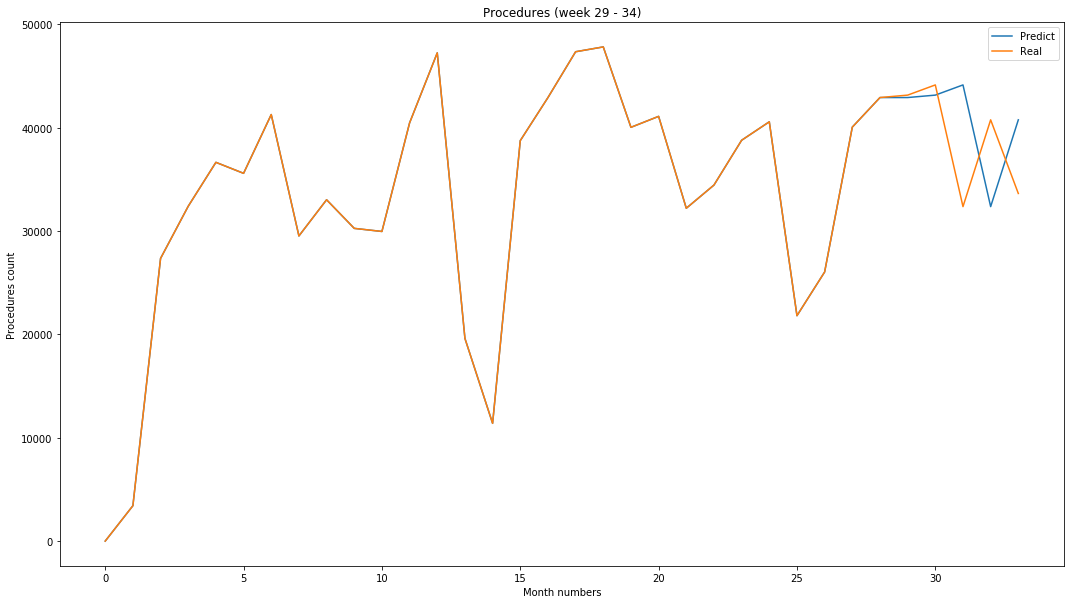

In [88]:

plt.plot(predict_ProcB)
plt.plot(proceduresAll)
plt.title(s)
plt.xlabel('Month numbers')
plt.ylabel('Procedures count')
plt.legend(('Predict', 'Real'))

(20000, 50000)

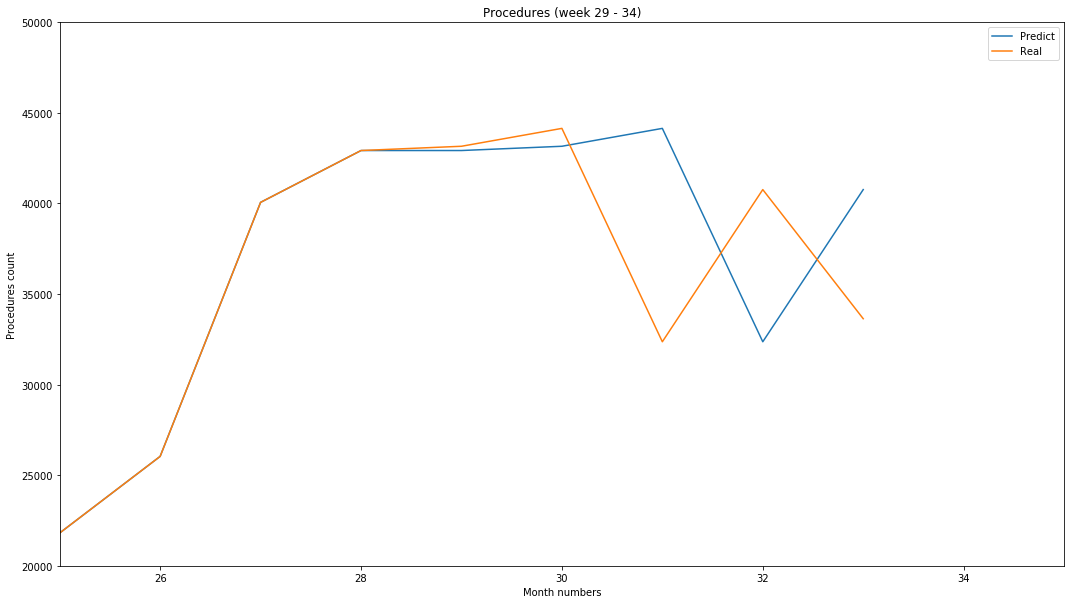

In [89]:
plt.plot(predict_ProcB)
plt.plot(proceduresAll)
plt.title(s)
plt.xlabel('Month numbers')
plt.ylabel('Procedures count')
plt.legend(('Predict', 'Real'))
plt.xlim(25, 35)
plt.ylim(20000, 50000)

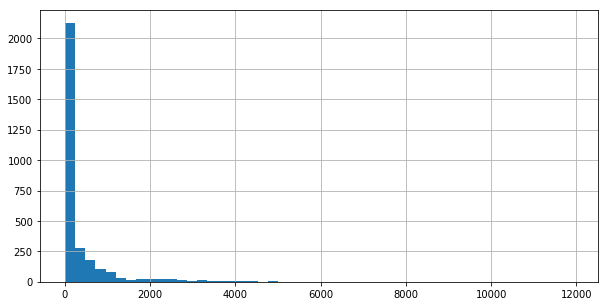

In [90]:
melt2['Proc'].hist(bins=50, figsize=(10,5))

In [91]:
%%time
mean_errorLR2 = []
mean_errorRF2 = []
mean_errorGB2 = []

mean_errorEC2 = []


total_errorLR2 = []
predict_ProcLR2 = copy.copy(procedures)
abs_pr_errorLR2 = []

total_errorRF2 = []
predict_ProcRF2 = copy.copy(procedures)
abs_pr_errorRF2 = []

total_errorGB2 = []
predict_ProcGB2 = copy.copy(procedures)
abs_pr_errorGB2 = []

total_errorEC2 = []
predict_ProcEC2 = copy.copy(procedures)
abs_pr_errorEC2 = []
for Month in range(month_start, month_end):
    train = melt2[melt2['Month'] < Month]
    val = melt2[melt2['Month'] == Month]

    xtr, xts = train.drop(['Proc'], axis=1), val.drop(['Proc'], axis=1)
    ytr, yts = train['Proc'].values, val['Proc'].values
    #Делаем предсказания для линеной регрессии, смотрим ошибку и сохнаняем данные
    mdl = LinearRegression()
    mdl.fit(xtr, ytr)
    
    plr = mdl.predict(xts)
    total_yts=sum(yts)
    total_plr=sum(plr)
    
    errorLR2 = rmsle(yts, plr)
    abs_errorLR2 = abs(total_yts-total_plr)
    abs_prLR2 = abs_errorLR2/total_yts*100
    
    mean_errorLR2.append(errorLR2)
    total_errorLR2.append(abs_errorLR2)
    predict_ProcLR2.append(total_plr)
    abs_pr_errorLR2.append(abs_prLR2)
    
    #Делаем предсказания при помощи случайного леса, смотрим ошибку и сохнаняем данные    
    mdlrf = RandomForestRegressor(n_estimators=1000, n_jobs=-1, random_state=0)
    mdlrf.fit(xtr, ytr)
    
    prf = mdlrf.predict(xts)
    total_prf=sum(prf)
    
    errorRF2 = rmsle(yts, prf)
    abs_errorRF2 = abs(total_yts-total_prf)
    abs_prRF2 = abs_errorRF2/total_yts*100
    
    mean_errorRF2.append(errorRF2)
    total_errorRF2.append(abs_errorRF2)
    predict_ProcRF2.append(total_prf)
    abs_pr_errorRF2.append(abs_prRF2)
    
    #Делаем предсказания градиентным бустингом, смотрим ошибку и сохраняем данные
    mdlgb = LGBMRegressor(n_estimators=1000, learning_rate=0.01)
    mdlgb.fit(xtr, np.log1p(ytr))
    
    pgb = np.expm1(mdlgb.predict(xts))
    total_pgb=sum(pgb)
    
    errorGB2 = rmsle(yts, pgb)
    abs_errorGB2 = abs(total_yts-total_pgb)
    abs_prGB2 = abs_errorGB2/total_yts*100
    
    mean_errorGB2.append(errorGB2)
    total_errorGB2.append(abs_errorGB2)
    predict_ProcGB2.append(total_pgb)
    abs_pr_errorGB2.append(abs_prGB2)

    #Делаем "среднее" предсказание из трех предыдущих
    plr = pd.DataFrame({'PrLr': plr})
    plr.reset_index(inplace=True)
    prf = pd.DataFrame({'PrRf': prf})
    prf.reset_index(inplace=True)
    plr=plr.merge( prf, how = 'inner', left_on = 'index', right_on = 'index' )
    pgb = pd.DataFrame({'PrGb': pgb})
    pgb.reset_index(inplace=True)
    plr=plr.merge( pgb, how = 'inner', left_on = 'index', right_on = 'index' ) 
    plr['s']=plr.PrLr/3+plr.PrRf/3+plr.PrGb/3
 
    pEC2=plr['s']

    total_yts=sum(yts)
    total_pec=sum(pEC2)

    errorEC2 = rmsle(yts, pEC2)
    abs_errorEC2 = abs(total_yts-total_pec)
    abs_prEC2 = abs_errorEC2/total_yts*100
    
    mean_errorEC2.append(errorEC2)
    total_errorEC2.append(abs_errorEC2)
    predict_ProcEC2.append(total_pec)
    abs_pr_errorEC2.append(abs_prEC2)
    print('Month %d' % (Month))
    print('LR2 - Error %.5f, Real Total %.1f - Predict Total %.1f, Abs Error %.1f, Persent - %.1f' % (errorLR2, total_yts, total_plr, abs_errorLR2, abs_prLR2))
    print('RF2 - Error %.5f, Real Total %.1f - Predict Total %.1f, Abs Error %.1f, Persent - %.1f' % (errorRF2, total_yts, total_prf, abs_errorRF2, abs_prRF2))
    print('GB2 - Error %.5f, Real Total %.1f - Predict Total %.1f, Abs Error %.1f, Persent - %.1f' % (errorGB2, total_yts, total_pgb, abs_errorGB2, abs_prGB2))
    print('EC2 - Error %.5f, Real Total %.1f - Predict Total %.1f, Abs Error %.1f, Persent - %.1f' % (errorEC2, total_yts, total_pec, abs_errorEC2, abs_prEC2))
print('Mean Error')
print('LR2 = %.5f, RF2 = %.5f, GB2 = %.5f, EC2 = %.5f' % (np.mean(mean_errorLR2), np.mean(mean_errorRF2), np.mean(mean_errorGB2), np.mean(mean_errorEC2)))
print('Mean Abs Error')
print('LR2 = %.1f, RF2 = %.1f, GB2 = %.1f, EC2 = %.1f' % (np.mean(total_errorLR2), np.mean(total_errorRF2), np.mean(total_errorGB2), np.mean(total_errorEC2)))
print('Mean Abs Error persent')
print('LR2 = %.1f, RF2 = %.1f, GB2 = %.1f, EC2 = %.1f' % (np.mean(abs_pr_errorLR2), np.mean(abs_pr_errorRF2), np.mean(abs_pr_errorGB2), np.mean(abs_pr_errorEC2)))

Month 29
LR2 - Error 1.13776, Real Total 43153.0 - Predict Total 42973.9, Abs Error 179.1, Persent - 0.4
RF2 - Error 0.52795, Real Total 43153.0 - Predict Total 47617.0, Abs Error 4464.0, Persent - 10.3
GB2 - Error 0.39405, Real Total 43153.0 - Predict Total 43814.3, Abs Error 661.3, Persent - 1.5
EC2 - Error 0.81927, Real Total 43153.0 - Predict Total 44801.8, Abs Error 1648.8, Persent - 3.8
Month 30
LR2 - Error 1.09854, Real Total 44140.0 - Predict Total 43261.4, Abs Error 878.6, Persent - 2.0
RF2 - Error 0.45603, Real Total 44140.0 - Predict Total 44825.4, Abs Error 685.4, Persent - 1.6
GB2 - Error 0.33860, Real Total 44140.0 - Predict Total 44289.5, Abs Error 149.5, Persent - 0.3
EC2 - Error 0.76701, Real Total 44140.0 - Predict Total 44125.4, Abs Error 14.6, Persent - 0.0
Month 31
LR2 - Error 1.24212, Real Total 32364.0 - Predict Total 44327.7, Abs Error 11963.7, Persent - 37.0
RF2 - Error 0.56924, Real Total 32364.0 - Predict Total 42749.7, Abs Error 10385.7, Persent - 32.1
GB2 -

(20000, 50000)

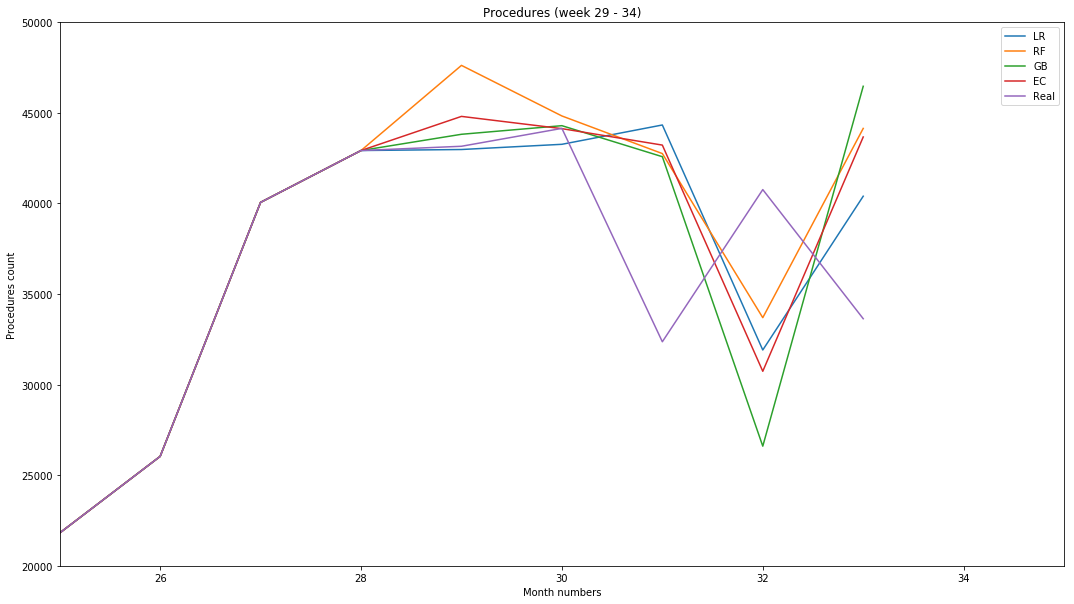

In [92]:
plt.plot(predict_ProcLR2)
plt.plot(predict_ProcRF2)
plt.plot(predict_ProcGB2)
plt.plot(predict_ProcEC2)
plt.plot(proceduresAll)
plt.title(s)
plt.xlabel('Month numbers')
plt.ylabel('Procedures count')
plt.legend(('LR', 'RF', 'GB', 'EC', 'Real'))
plt.xlim(25, 35)
plt.ylim(20000, 50000)

In [93]:
melt3 = melt.copy()
melt3['Last_Month_Proc'] = melt3.groupby(['RegCode'])['Proc'].shift()
melt3['Last_Month_Diff'] = melt3.groupby(['RegCode'])['Last_Month_Proc'].diff()
melt3['Last-1_Month_Proc'] = melt3.groupby(['RegCode'])['Proc'].shift(2)
melt3['Last-1_Month_Diff'] = melt3.groupby(['RegCode'])['Last-1_Month_Proc'].diff()
melt3 = melt3.dropna()
melt3.head()

,RegCode,Month,Proc,Last_Month_Proc,Last_Month_Diff,Last-1_Month_Proc,Last-1_Month_Diff
264,1,4,566,777.0,223.0,554.0,459.0
352,1,5,701,566.0,-211.0,777.0,223.0
440,1,6,1189,701.0,135.0,566.0,-211.0
528,1,7,476,1189.0,488.0,701.0,135.0
616,1,8,639,476.0,-713.0,1189.0,488.0


In [94]:
%%time
mean_errorLR3 = []
mean_errorRF3 = []
mean_errorGB3 = []

mean_errorEC3 = []


total_errorLR3 = []
predict_ProcLR3 = copy.copy(procedures)
abs_pr_errorLR3 = []

total_errorRF3 = []
predict_ProcRF3 = copy.copy(procedures)
abs_pr_errorRF3 = []

total_errorGB3 = []
predict_ProcGB3 = copy.copy(procedures)
abs_pr_errorGB3 = []

total_errorEC3 = []
predict_ProcEC3 = copy.copy(procedures)
abs_pr_errorEC3 = []
for Month in range(month_start, month_end):
    train = melt3[melt3['Month'] < Month]
    val = melt3[melt3['Month'] == Month]

    xtr, xts = train.drop(['Proc'], axis=1), val.drop(['Proc'], axis=1)
    ytr, yts = train['Proc'].values, val['Proc'].values
    #Делаем предсказания для линеной регрессии, смотрим ошибку и сохнаняем данные
    mdl = LinearRegression()
    mdl.fit(xtr, ytr)
    
    plr = mdl.predict(xts)
    total_yts=sum(yts)
    total_plr=sum(plr)
    
    plr = abs(plr)
    errorLR3 = rmsle(yts, abs(plr))
    abs_errorLR3 = abs(total_yts-total_plr)
    abs_prLR3 = abs_errorLR3/total_yts*100
    
    mean_errorLR3.append(errorLR3)
    total_errorLR3.append(abs_errorLR3)
    predict_ProcLR3.append(total_plr)
    abs_pr_errorLR3.append(abs_prLR3)
    
    #Делаем предсказания при помощи случайного леса, смотрим ошибку и сохнаняем данные    
    mdlrf = RandomForestRegressor(n_estimators=1000, n_jobs=-1, random_state=0)
    mdlrf.fit(xtr, ytr)
    
    prf = mdlrf.predict(xts)
    total_prf=sum(prf)
    
    prf = abs(prf)
    errorRF3 = rmsle(yts, prf)
    abs_errorRF3 = abs(total_yts-total_prf)
    abs_prRF3 = abs_errorRF3/total_yts*100
    
    mean_errorRF3.append(errorRF3)
    total_errorRF3.append(abs_errorRF3)
    predict_ProcRF3.append(total_prf)
    abs_pr_errorRF3.append(abs_prRF3)
    
    #Делаем предсказания градиентным бустингом, смотрим ошибку и сохраняем данные
    mdlgb = LGBMRegressor(n_estimators=1000, learning_rate=0.01)
    mdlgb.fit(xtr, np.log1p(ytr))
    
    pgb = np.expm1(mdlgb.predict(xts))
    total_pgb=sum(pgb)
    
    pgb = abs(pgb)
    errorGB3 = rmsle(yts, pgb)
    abs_errorGB3 = abs(total_yts-total_pgb)
    abs_prGB3 = abs_errorGB3/total_yts*100
    
    mean_errorGB3.append(errorGB3)
    total_errorGB3.append(abs_errorGB3)
    predict_ProcGB3.append(total_pgb)
    abs_pr_errorGB3.append(abs_prGB3)

    #Делаем "среднее" предсказание из трех предыдущих
    plr = pd.DataFrame({'PrLr': plr})
    plr.reset_index(inplace=True)
    prf = pd.DataFrame({'PrRf': prf})
    prf.reset_index(inplace=True)
    plr=plr.merge( prf, how = 'inner', left_on = 'index', right_on = 'index' )
    pgb = pd.DataFrame({'PrGb': pgb})
    pgb.reset_index(inplace=True)
    plr=plr.merge( pgb, how = 'inner', left_on = 'index', right_on = 'index' ) 
    plr['s']=plr.PrLr/3+plr.PrRf/3+plr.PrGb/3
 
    pEC3=plr['s']

    total_yts=sum(yts)
    total_pec=sum(pEC3)

    errorEC3 = rmsle(yts, pEC3)
    abs_errorEC3 = abs(total_yts-total_pec)
    abs_prEC3 = abs_errorEC3/total_yts*100
    
    mean_errorEC3.append(errorEC3)
    total_errorEC3.append(abs_errorEC3)
    predict_ProcEC3.append(total_pec)
    abs_pr_errorEC3.append(abs_prEC3)
    print('Month %d' % (Month))
    print('LR3 - Error %.5f, Real Total %.1f - Predict Total %.1f, Abs Error %.1f, Persent - %.1f' % (errorLR3, total_yts, total_plr, abs_errorLR3, abs_prLR3))
    print('RF3 - Error %.5f, Real Total %.1f - Predict Total %.1f, Abs Error %.1f, Persent - %.1f' % (errorRF3, total_yts, total_prf, abs_errorRF3, abs_prRF3))
    print('GB3 - Error %.5f, Real Total %.1f - Predict Total %.1f, Abs Error %.1f, Persent - %.1f' % (errorGB3, total_yts, total_pgb, abs_errorGB3, abs_prGB3))
    print('EC3 - Error %.5f, Real Total %.1f - Predict Total %.1f, Abs Error %.1f, Persent - %.1f' % (errorEC3, total_yts, total_pec, abs_errorEC3, abs_prEC3))
print('Mean Error')
print('LR3 = %.5f, RF3 = %.5f, GB3 = %.5f, EC3 = %.5f' % (np.mean(mean_errorLR3), np.mean(mean_errorRF3), np.mean(mean_errorGB3), np.mean(mean_errorEC3)))
print('Mean Abs Error')
print('LR3 = %.1f, RF3 = %.1f, GB3 = %.1f, EC3 = %.1f' % (np.mean(total_errorLR3), np.mean(total_errorRF3), np.mean(total_errorGB3), np.mean(total_errorEC3)))
print('Mean Abs Error persent')
print('LR3 = %.1f, RF3 = %.1f, GB3 = %.1f, EC3 = %.1f' % (np.mean(abs_pr_errorLR3), np.mean(abs_pr_errorRF3), np.mean(abs_pr_errorGB3), np.mean(abs_pr_errorEC3)))

Month 29
LR3 - Error 0.94454, Real Total 43153.0 - Predict Total 38638.4, Abs Error 4514.6, Persent - 10.5
RF3 - Error 0.54661, Real Total 43153.0 - Predict Total 44787.2, Abs Error 1634.2, Persent - 3.8
GB3 - Error 0.43481, Real Total 43153.0 - Predict Total 45814.4, Abs Error 2661.4, Persent - 6.2
EC3 - Error 0.70691, Real Total 43153.0 - Predict Total 43080.0, Abs Error 73.0, Persent - 0.2
Month 30
LR3 - Error 0.99523, Real Total 44140.0 - Predict Total 42674.9, Abs Error 1465.1, Persent - 3.3
RF3 - Error 0.42853, Real Total 44140.0 - Predict Total 43763.4, Abs Error 376.6, Persent - 0.9
GB3 - Error 0.33874, Real Total 44140.0 - Predict Total 42363.8, Abs Error 1776.2, Persent - 4.0
EC3 - Error 0.68942, Real Total 44140.0 - Predict Total 42934.0, Abs Error 1206.0, Persent - 2.7
Month 31
LR3 - Error 1.16471, Real Total 32364.0 - Predict Total 44431.9, Abs Error 12067.9, Persent - 37.3
RF3 - Error 0.56586, Real Total 32364.0 - Predict Total 42506.5, Abs Error 10142.5, Persent - 31.3
G

(20000, 50000)

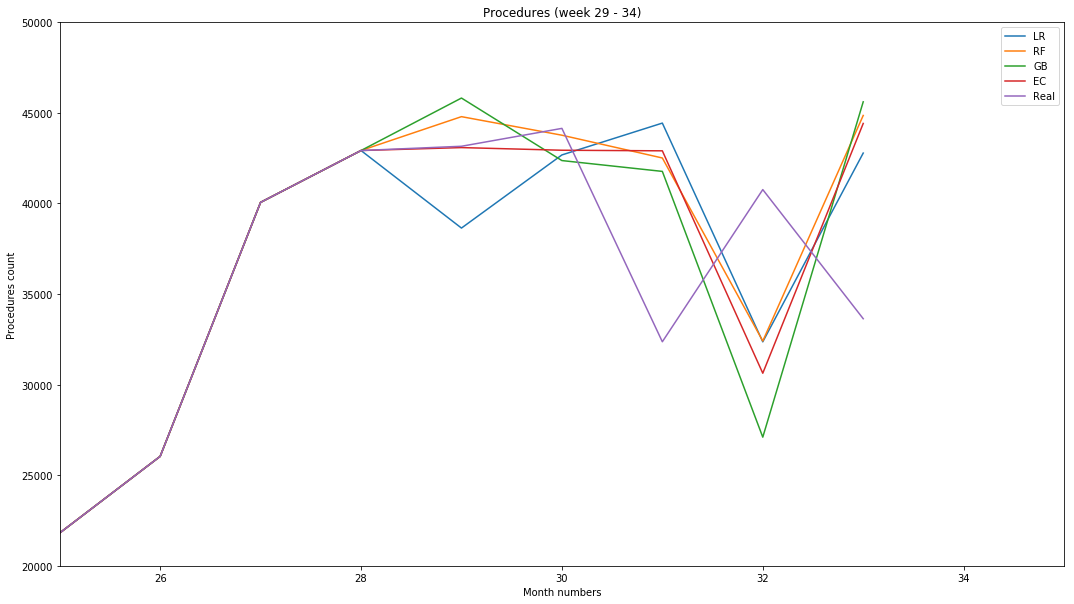

In [95]:
plt.plot(predict_ProcLR3)
plt.plot(predict_ProcRF3)
plt.plot(predict_ProcGB3)
plt.plot(predict_ProcEC3)
plt.plot(proceduresAll)
plt.title(s)
plt.xlabel('Month numbers')
plt.ylabel('Procedures count')
plt.legend(('LR', 'RF', 'GB', 'EC', 'Real'))
plt.xlim(25, 35)
plt.ylim(20000, 50000)

In [96]:
melt4 = melt.copy()
melt4['Last_Month_Proc'] = melt4.groupby(['RegCode'])['Proc'].shift()
melt4['Last_Month_Diff'] = melt4.groupby(['RegCode'])['Last_Month_Proc'].diff()
melt4['Last-1_Month_Proc'] = melt4.groupby(['RegCode'])['Proc'].shift(2)
melt4['Last-1_Month_Diff'] = melt4.groupby(['RegCode'])['Last-1_Month_Proc'].diff()
melt4['Last-2_Month_Proc'] = melt4.groupby(['RegCode'])['Proc'].shift(3)
melt4['Last-2_Month_Diff'] = melt4.groupby(['RegCode'])['Last-2_Month_Proc'].diff()
melt4 = melt4.dropna()
melt4.head()

,RegCode,Month,Proc,Last_Month_Proc,Last_Month_Diff,Last-1_Month_Proc,Last-1_Month_Diff,Last-2_Month_Proc,Last-2_Month_Diff
352,1,5,701,566.0,-211.0,777.0,223.0,554.0,459.0
440,1,6,1189,701.0,135.0,566.0,-211.0,777.0,223.0
528,1,7,476,1189.0,488.0,701.0,135.0,566.0,-211.0
616,1,8,639,476.0,-713.0,1189.0,488.0,701.0,135.0
704,1,9,579,639.0,163.0,476.0,-713.0,1189.0,488.0


In [97]:
%%time
mean_errorLR4 = []
mean_errorRF4 = []
mean_errorGB4 = []

mean_errorEC4 = []


total_errorLR4 = []
predict_ProcLR4 = copy.copy(procedures)
abs_pr_errorLR4 = []

total_errorRF4 = []
predict_ProcRF4 = copy.copy(procedures)
abs_pr_errorRF4 = []

total_errorGB4 = []
predict_ProcGB4 = copy.copy(procedures)
abs_pr_errorGB4 = []

total_errorEC4 = []
predict_ProcEC4 = copy.copy(procedures)
abs_pr_errorEC4 = []
for Month in range(month_start, month_end):
    train = melt4[melt4['Month'] < Month]
    val = melt4[melt4['Month'] == Month]

    xtr, xts = train.drop(['Proc'], axis=1), val.drop(['Proc'], axis=1)
    ytr, yts = train['Proc'].values, val['Proc'].values
    #Делаем предсказания для линеной регрессии, смотрим ошибку и сохнаняем данные
    mdl = LinearRegression()
    mdl.fit(xtr, ytr)
    
    plr = mdl.predict(xts)
    total_yts=sum(yts)
    total_plr=sum(plr)
    
    errorLR4 = rmsle(yts, plr)
    abs_errorLR4 = abs(total_yts-total_plr)
    abs_prLR4 = abs_errorLR4/total_yts*100
    
    mean_errorLR4.append(errorLR4)
    total_errorLR4.append(abs_errorLR4)
    predict_ProcLR4.append(total_plr)
    abs_pr_errorLR4.append(abs_prLR4)
    
    #Делаем предсказания при помощи случайного леса, смотрим ошибку и сохнаняем данные    
    mdlrf = RandomForestRegressor(n_estimators=1000, n_jobs=-1, random_state=0)
    mdlrf.fit(xtr, ytr)
    
    prf = mdlrf.predict(xts)
    total_prf=sum(prf)
    
    errorRF4 = rmsle(yts, prf)
    abs_errorRF4 = abs(total_yts-total_prf)
    abs_prRF4 = abs_errorRF4/total_yts*100
    
    mean_errorRF4.append(errorRF4)
    total_errorRF4.append(abs_errorRF4)
    predict_ProcRF4.append(total_prf)
    abs_pr_errorRF4.append(abs_prRF4)
    
    #Делаем предсказания градиентным бустингом, смотрим ошибку и сохраняем данные
    mdlgb = LGBMRegressor(n_estimators=1000, learning_rate=0.01)
    mdlgb.fit(xtr, np.log1p(ytr))
    
    pgb = np.expm1(mdlgb.predict(xts))
    total_pgb=sum(pgb)
    
    errorGB4 = rmsle(yts, pgb)
    abs_errorGB4 = abs(total_yts-total_pgb)
    abs_prGB4 = abs_errorGB4/total_yts*100
    
    mean_errorGB4.append(errorGB4)
    total_errorGB4.append(abs_errorGB4)
    predict_ProcGB4.append(total_pgb)
    abs_pr_errorGB4.append(abs_prGB4)

    #Делаем "среднее" предсказание из трех предыдущих
    plr = pd.DataFrame({'PrLr': plr})
    plr.reset_index(inplace=True)
    prf = pd.DataFrame({'PrRf': prf})
    prf.reset_index(inplace=True)
    plr=plr.merge( prf, how = 'inner', left_on = 'index', right_on = 'index' )
    pgb = pd.DataFrame({'PrGb': pgb})
    pgb.reset_index(inplace=True)
    plr=plr.merge( pgb, how = 'inner', left_on = 'index', right_on = 'index' ) 
    plr['s']=plr.PrLr/3+plr.PrRf/3+plr.PrGb/3
 
    pEC4=plr['s']

    total_yts=sum(yts)
    total_pec=sum(pEC4)

    errorEC4 = rmsle(yts, pEC4)
    abs_errorEC4 = abs(total_yts-total_pec)
    abs_prEC4 = abs_errorEC4/total_yts*100
    
    mean_errorEC4.append(errorEC4)
    total_errorEC4.append(abs_errorEC4)
    predict_ProcEC4.append(total_pec)
    abs_pr_errorEC4.append(abs_prEC4)
    print('Month %d' % (Month))
    print('LR4 - Error %.5f, Real Total %.1f - Predict Total %.1f, Abs Error %.1f, Persent - %.1f' % (errorLR4, total_yts, total_plr, abs_errorLR4, abs_prLR4))
    print('RF4 - Error %.5f, Real Total %.1f - Predict Total %.1f, Abs Error %.1f, Persent - %.1f' % (errorRF4, total_yts, total_prf, abs_errorRF4, abs_prRF4))
    print('GB4 - Error %.5f, Real Total %.1f - Predict Total %.1f, Abs Error %.1f, Persent - %.1f' % (errorGB4, total_yts, total_pgb, abs_errorGB4, abs_prGB4))
    print('EC4 - Error %.5f, Real Total %.1f - Predict Total %.1f, Abs Error %.1f, Persent - %.1f' % (errorEC4, total_yts, total_pec, abs_errorEC4, abs_prEC4))
print('Mean Error')
print('LR4 = %.5f, RF4 = %.5f, GB4 = %.5f, EC4 = %.5f' % (np.mean(mean_errorLR4), np.mean(mean_errorRF4), np.mean(mean_errorGB4), np.mean(mean_errorEC4)))
print('Mean Abs Error')
print('LR4 = %.1f, RF4 = %.1f, GB4 = %.1f, EC4 = %.1f' % (np.mean(total_errorLR4), np.mean(total_errorRF4), np.mean(total_errorGB4), np.mean(total_errorEC4)))
print('Mean Abs Error persent')
print('LR4 = %.1f, RF4 = %.1f, GB4 = %.1f, EC4 = %.1f' % (np.mean(abs_pr_errorLR4), np.mean(abs_pr_errorRF4), np.mean(abs_pr_errorGB4), np.mean(abs_pr_errorEC4)))

Month 29
LR4 - Error 1.08028, Real Total 43153.0 - Predict Total 37406.7, Abs Error 5746.3, Persent - 13.3
RF4 - Error 0.48027, Real Total 43153.0 - Predict Total 43607.8, Abs Error 454.8, Persent - 1.1
GB4 - Error 0.42860, Real Total 43153.0 - Predict Total 44584.7, Abs Error 1431.7, Persent - 3.3
EC4 - Error 0.77406, Real Total 43153.0 - Predict Total 41866.4, Abs Error 1286.6, Persent - 3.0
Month 30
LR4 - Error 1.16091, Real Total 44140.0 - Predict Total 42676.6, Abs Error 1463.4, Persent - 3.3
RF4 - Error 0.41076, Real Total 44140.0 - Predict Total 43964.6, Abs Error 175.4, Persent - 0.4
GB4 - Error 0.32741, Real Total 44140.0 - Predict Total 42484.3, Abs Error 1655.7, Persent - 3.8
EC4 - Error 0.79214, Real Total 44140.0 - Predict Total 43041.8, Abs Error 1098.2, Persent - 2.5
Month 31
LR4 - Error 1.35181, Real Total 32364.0 - Predict Total 45147.0, Abs Error 12783.0, Persent - 39.5
RF4 - Error 0.58580, Real Total 32364.0 - Predict Total 42724.2, Abs Error 10360.2, Persent - 32.0


(20000, 50000)

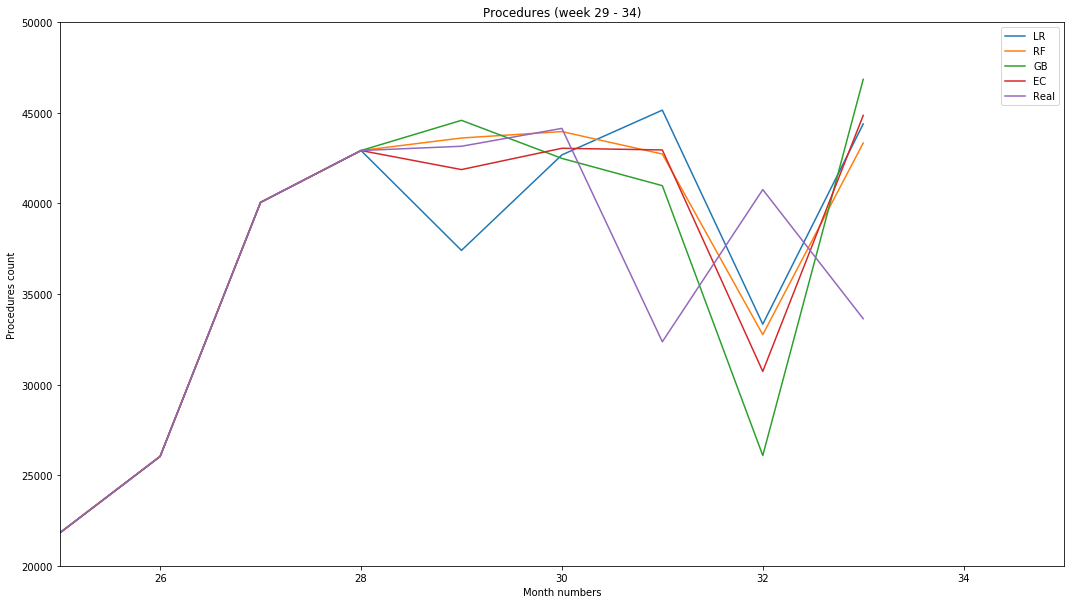

In [98]:
plt.plot(predict_ProcLR4)
plt.plot(predict_ProcRF4)
plt.plot(predict_ProcGB4)
plt.plot(predict_ProcEC4)
plt.plot(proceduresAll)
plt.title(s)
plt.xlabel('Month numbers')
plt.ylabel('Procedures count')
plt.legend(('LR', 'RF', 'GB', 'EC', 'Real'))
plt.xlim(25, 35)
plt.ylim(20000, 50000)

In [99]:
%%time
mean_errorRF4_n = []
total_errorRF4_n = []
ProcRF4_n = copy.copy(procedures)
predict_ProcRF4_n = copy.copy(procedures)
abs_pr_errorRF4_n = []
for month in range(month_start, month_end):
    train = melt4[melt4['Month'] < month]
    val = melt4[melt4['Month'] == month]
    
    xtr, xts = train.drop(['Proc'], axis=1), val.drop(['Proc'], axis=1)
    ytr, yts = train['Proc'].values, val['Proc'].values
    
    mdl = RandomForestRegressor(n_estimators=1000, n_jobs=-1, random_state=0)
    mdl.fit(xtr, np.log1p(ytr))
    
    p = np.expm1(mdl.predict(xts))
    
    total_yts=sum(yts)
    total_p=sum(p)
    
    error = rmsle(yts, p)
    abs_error = abs(total_yts-total_p)
    abs_pr = abs_error/total_yts*100

    print('Month %d - Error %.5f, Real Total %.1f - Predict Total %.1f, Abs Error %.1f, Persent - %.1f' % (month, error, total_yts, total_p, abs_error, abs_pr))
    mean_errorRF4_n.append(error)
    total_errorRF4_n.append(abs_error)
    ProcRF4_n.append(total_yts)
    predict_ProcRF4_n.append(total_p)
    abs_pr_errorRF4_n.append(abs_pr)
print('Mean Error = %.5f' % np.mean(mean_errorRF4_n))
print('Mean Abs Error = %.5f' % np.mean(total_errorRF4_n))
print('Mean Abs Error persent = %.5f' % np.mean(abs_pr_errorRF4_n))

Month 29 - Error 0.40479, Real Total 43153.0 - Predict Total 38690.3, Abs Error 4462.7, Persent - 10.3
Month 30 - Error 0.32385, Real Total 44140.0 - Predict Total 41454.9, Abs Error 2685.1, Persent - 6.1
Month 31 - Error 0.47357, Real Total 32364.0 - Predict Total 41111.2, Abs Error 8747.2, Persent - 27.0
Month 32 - Error 0.48336, Real Total 40762.0 - Predict Total 30025.5, Abs Error 10736.5, Persent - 26.3
Month 33 - Error 0.42749, Real Total 33636.0 - Predict Total 39837.6, Abs Error 6201.6, Persent - 18.4
Mean Error = 0.42261
Mean Abs Error = 6566.60323
Mean Abs Error persent = 17.64580
Wall time: 29.8 s


In [100]:
%%time
melt12 = melt.copy()
melt12['Last_Month_Proc'] = melt12.groupby(['RegCode'])['Proc'].shift()
melt12['Last_Month_Diff'] = melt12.groupby(['RegCode'])['Last_Month_Proc'].diff()
melt12['Last-1_Month_Proc'] = melt12.groupby(['RegCode'])['Proc'].shift(2)
melt12['Last-1_Month_Diff'] = melt12.groupby(['RegCode'])['Last-1_Month_Proc'].diff()
melt12['Last-2_Month_Proc'] = melt12.groupby(['RegCode'])['Proc'].shift(3)
melt12['Last-2_Month_Diff'] = melt12.groupby(['RegCode'])['Last-2_Month_Proc'].diff()
melt12['Last-3_Month_Proc'] = melt12.groupby(['RegCode'])['Proc'].shift(3)
melt12['Last-3_Month_Diff'] = melt12.groupby(['RegCode'])['Last-3_Month_Proc'].diff()
melt12['Last-4_Month_Proc'] = melt12.groupby(['RegCode'])['Proc'].shift(3)
melt12['Last-4_Month_Diff'] = melt12.groupby(['RegCode'])['Last-4_Month_Proc'].diff()
melt12['Last-5_Month_Proc'] = melt12.groupby(['RegCode'])['Proc'].shift(3)
melt12['Last-5_Month_Diff'] = melt12.groupby(['RegCode'])['Last-5_Month_Proc'].diff()
melt12['Last-6_Month_Proc'] = melt12.groupby(['RegCode'])['Proc'].shift(3)
melt12['Last-6_Month_Diff'] = melt12.groupby(['RegCode'])['Last-6_Month_Proc'].diff()
melt12['Last-7_Month_Proc'] = melt12.groupby(['RegCode'])['Proc'].shift(3)
melt12['Last-7_Month_Diff'] = melt12.groupby(['RegCode'])['Last-7_Month_Proc'].diff()
melt12['Last-8_Month_Proc'] = melt12.groupby(['RegCode'])['Proc'].shift(3)
melt12['Last-8_Month_Diff'] = melt12.groupby(['RegCode'])['Last-8_Month_Proc'].diff()
melt12['Last-9_Month_Proc'] = melt12.groupby(['RegCode'])['Proc'].shift(3)
melt12['Last-9_Month_Diff'] = melt12.groupby(['RegCode'])['Last-9_Month_Proc'].diff()
melt12['Last-10_Month_Proc'] = melt12.groupby(['RegCode'])['Proc'].shift(3)
melt12['Last-10_Month_Diff'] = melt12.groupby(['RegCode'])['Last-10_Month_Proc'].diff()
melt12['Last-11_Month_Proc'] = melt12.groupby(['RegCode'])['Proc'].shift(2)
melt12['Last-11_Month_Diff'] = melt12.groupby(['RegCode'])['Last-11_Month_Proc'].diff()
melt12['Last-12_Month_Proc'] = melt12.groupby(['RegCode'])['Proc'].shift(3)
melt12['Last-12_Month_Diff'] = melt12.groupby(['RegCode'])['Last-12_Month_Proc'].diff()
melt12 = melt12.dropna()
melt12.head()

Wall time: 327 ms


In [101]:
%%time
mean_errorLR12 = []
mean_errorRF12 = []
mean_errorGB12 = []

mean_errorEC12 = []


total_errorLR12 = []
predict_ProcLR12 = copy.copy(procedures)
abs_pr_errorLR12 = []

total_errorRF12 = []
predict_ProcRF12 = copy.copy(procedures)
abs_pr_errorRF12 = []

total_errorGB12 = []
predict_ProcGB12 = copy.copy(procedures)
abs_pr_errorGB12 = []

total_errorEC12 = []
predict_ProcEC12 = copy.copy(procedures)
abs_pr_errorEC12 = []
for Month in range(month_start, month_end):
    train = melt12[melt12['Month'] < Month]
    val = melt12[melt12['Month'] == Month]

    xtr, xts = train.drop(['Proc'], axis=1), val.drop(['Proc'], axis=1)
    ytr, yts = train['Proc'].values, val['Proc'].values
    #Делаем предсказания для линеной регрессии, смотрим ошибку и сохнаняем данные
    mdl = LinearRegression()
    mdl.fit(xtr, ytr)
    
    plr = mdl.predict(xts)
    total_yts=sum(yts)
    total_plr=sum(plr)
    
    errorLR12 = rmsle(yts, plr)
    abs_errorLR12 = abs(total_yts-total_plr)
    abs_prLR12 = abs_errorLR12/total_yts*100
    
    mean_errorLR12.append(errorLR12)
    total_errorLR12.append(abs_errorLR12)
    predict_ProcLR12.append(total_plr)
    abs_pr_errorLR12.append(abs_prLR12)
    
    #Делаем предсказания при помощи случайного леса, смотрим ошибку и сохнаняем данные    
    mdlrf = RandomForestRegressor(n_estimators=1000, n_jobs=-1, random_state=0)
    mdlrf.fit(xtr, ytr)
    
    prf = mdlrf.predict(xts)
    total_prf=sum(prf)
    
    errorRF12 = rmsle(yts, prf)
    abs_errorRF12 = abs(total_yts-total_prf)
    abs_prRF12 = abs_errorRF12/total_yts*100
    
    mean_errorRF12.append(errorRF12)
    total_errorRF12.append(abs_errorRF12)
    predict_ProcRF12.append(total_prf)
    abs_pr_errorRF12.append(abs_prRF12)
    
    #Делаем предсказания градиентным бустингом, смотрим ошибку и сохраняем данные
    mdlgb = LGBMRegressor(n_estimators=1000, learning_rate=0.01)
    mdlgb.fit(xtr, np.log1p(ytr))
    
    pgb = np.expm1(mdlgb.predict(xts))
    total_pgb=sum(pgb)
    
    errorGB12 = rmsle(yts, pgb)
    abs_errorGB12 = abs(total_yts-total_pgb)
    abs_prGB12 = abs_errorGB12/total_yts*100
    
    mean_errorGB12.append(errorGB12)
    total_errorGB12.append(abs_errorGB12)
    predict_ProcGB12.append(total_pgb)
    abs_pr_errorGB12.append(abs_prGB12)

    #Делаем "среднее" предсказание из трех предыдущих
    plr = pd.DataFrame({'PrLr': plr})
    plr.reset_index(inplace=True)
    prf = pd.DataFrame({'PrRf': prf})
    prf.reset_index(inplace=True)
    plr=plr.merge( prf, how = 'inner', left_on = 'index', right_on = 'index' )
    pgb = pd.DataFrame({'PrGb': pgb})
    pgb.reset_index(inplace=True)
    plr=plr.merge( pgb, how = 'inner', left_on = 'index', right_on = 'index' ) 
    plr['s']=plr.PrLr/3+plr.PrRf/3+plr.PrGb/3
 
    pEC12=plr['s']

    total_yts=sum(yts)
    total_pec=sum(pEC12)

    errorEC12 = rmsle(yts, pEC12)
    abs_errorEC12 = abs(total_yts-total_pec)
    abs_prEC12 = abs_errorEC12/total_yts*100
    
    mean_errorEC12.append(errorEC12)
    total_errorEC12.append(abs_errorEC12)
    predict_ProcEC12.append(total_pec)
    abs_pr_errorEC12.append(abs_prEC12)
    print('Month %d' % (Month))
    print('LR12 - Error %.5f, Real Total %.1f - Predict Total %.1f, Abs Error %.1f, Persent - %.1f' % (errorLR12, total_yts, total_plr, abs_errorLR12, abs_prLR12))
    print('RF12 - Error %.5f, Real Total %.1f - Predict Total %.1f, Abs Error %.1f, Persent - %.1f' % (errorRF12, total_yts, total_prf, abs_errorRF12, abs_prRF12))
    print('GB12 - Error %.5f, Real Total %.1f - Predict Total %.1f, Abs Error %.1f, Persent - %.1f' % (errorGB12, total_yts, total_pgb, abs_errorGB12, abs_prGB12))
    print('EC12 - Error %.5f, Real Total %.1f - Predict Total %.1f, Abs Error %.1f, Persent - %.1f' % (errorEC12, total_yts, total_pec, abs_errorEC12, abs_prEC12))
print('Mean Error')
print('LR12 = %.5f, RF12 = %.5f, GB12 = %.5f, EC12 = %.5f' % (np.mean(mean_errorLR12), np.mean(mean_errorRF12), np.mean(mean_errorGB12), np.mean(mean_errorEC12)))
print('Mean Abs Error')
print('LR12 = %.1f, RF12 = %.1f, GB12 = %.1f, EC12 = %.1f' % (np.mean(total_errorLR12), np.mean(total_errorRF12), np.mean(total_errorGB12), np.mean(total_errorEC12)))
print('Mean Abs Error persent')
print('LR12 = %.1f, RF12 = %.1f, GB12 = %.1f, EC12 = %.1f' % (np.mean(abs_pr_errorLR12), np.mean(abs_pr_errorRF12), np.mean(abs_pr_errorGB12), np.mean(abs_pr_errorEC12)))

Month 29
LR12 - Error 1.04938, Real Total 43153.0 - Predict Total 37533.7, Abs Error 5619.3, Persent - 13.0
RF12 - Error 0.48218, Real Total 43153.0 - Predict Total 43469.7, Abs Error 316.7, Persent - 0.7
GB12 - Error 0.42860, Real Total 43153.0 - Predict Total 44584.7, Abs Error 1431.7, Persent - 3.3
EC12 - Error 0.75280, Real Total 43153.0 - Predict Total 41862.7, Abs Error 1290.3, Persent - 3.0
Month 30
LR12 - Error 1.16081, Real Total 44140.0 - Predict Total 42541.0, Abs Error 1599.0, Persent - 3.6
RF12 - Error 0.41354, Real Total 44140.0 - Predict Total 43829.7, Abs Error 310.3, Persent - 0.7
GB12 - Error 0.32741, Real Total 44140.0 - Predict Total 42484.3, Abs Error 1655.7, Persent - 3.8
EC12 - Error 0.79206, Real Total 44140.0 - Predict Total 42951.6, Abs Error 1188.4, Persent - 2.7
Month 31
LR12 - Error 1.36149, Real Total 32364.0 - Predict Total 45350.0, Abs Error 12986.0, Persent - 40.1
RF12 - Error 0.58782, Real Total 32364.0 - Predict Total 42727.0, Abs Error 10363.0, Perse

(20000, 50000)

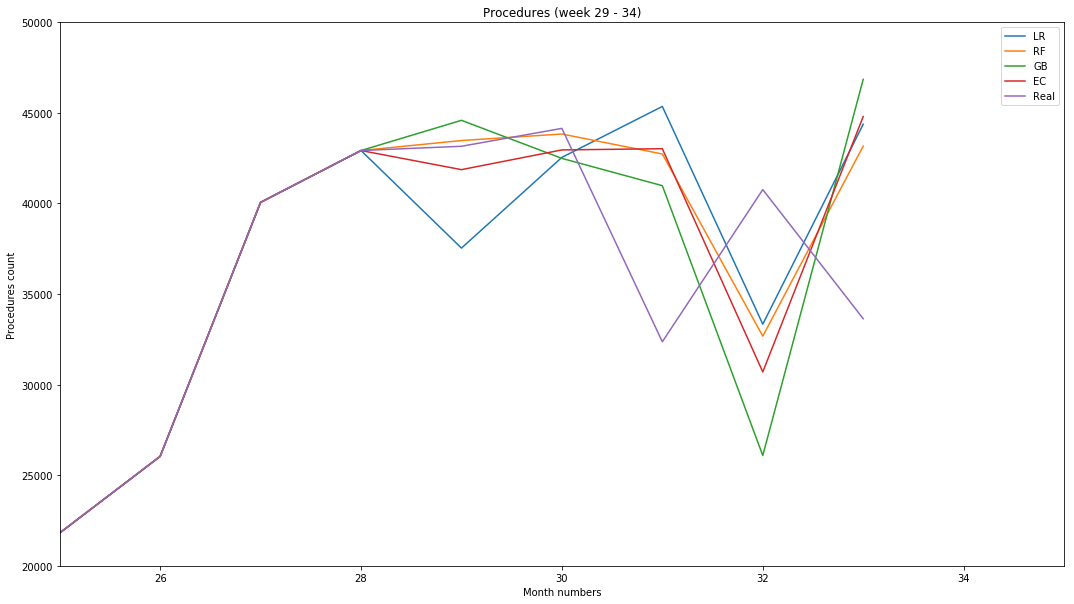

In [102]:
plt.plot(predict_ProcLR12)
plt.plot(predict_ProcRF12)
plt.plot(predict_ProcGB12)
plt.plot(predict_ProcEC12)
plt.plot(proceduresAll)
plt.title(s)
plt.xlabel('Month numbers')
plt.ylabel('Procedures count')
plt.legend(('LR', 'RF', 'GB', 'EC', 'Real'))
plt.xlim(25, 35)
plt.ylim(20000, 50000)

C:\Users\a.solodov\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\indexing.py:337: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
C:\Users\a.solodov\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\indexing.py:517: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


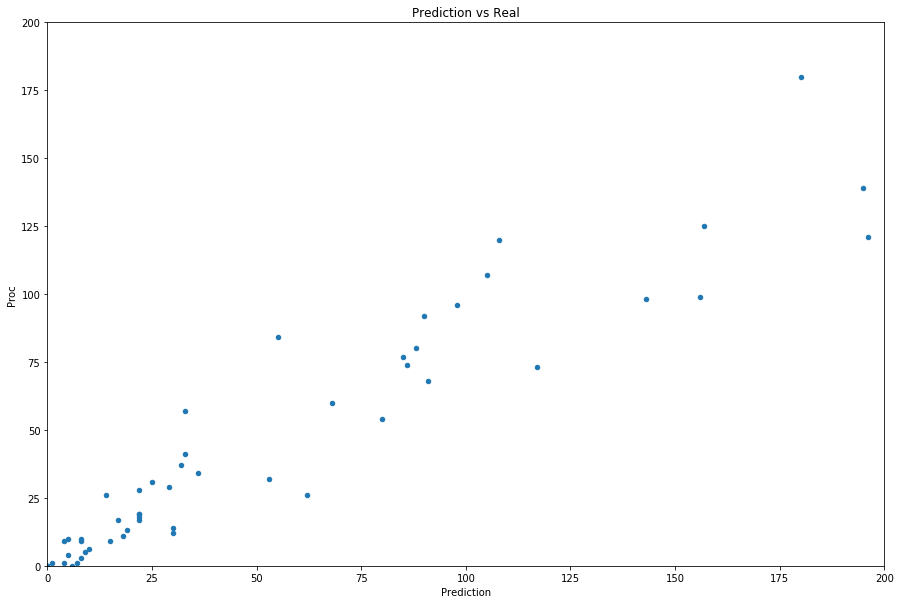

In [103]:
val.loc[:, 'Prediction'] = np.round(p)
val.plot.scatter(x='Prediction', y='Proc', figsize=(15,10), title='Prediction vs Real', 
                 ylim=(0,200), xlim=(0,200))

In [104]:
%%time
melt24 = melt.copy()
melt24['Last_Month_Proc'] = melt24.groupby(['RegCode'])['Proc'].shift()
melt24['Last_Month_Diff'] = melt24.groupby(['RegCode'])['Last_Month_Proc'].diff()
melt24['Last-1_Month_Proc'] = melt24.groupby(['RegCode'])['Proc'].shift(2)
melt24['Last-1_Month_Diff'] = melt24.groupby(['RegCode'])['Last-1_Month_Proc'].diff()
melt24['Last-2_Month_Proc'] = melt24.groupby(['RegCode'])['Proc'].shift(3)
melt24['Last-2_Month_Diff'] = melt24.groupby(['RegCode'])['Last-2_Month_Proc'].diff()
melt24['Last-3_Month_Proc'] = melt24.groupby(['RegCode'])['Proc'].shift(3)
melt24['Last-3_Month_Diff'] = melt24.groupby(['RegCode'])['Last-3_Month_Proc'].diff()
melt24['Last-4_Month_Proc'] = melt24.groupby(['RegCode'])['Proc'].shift(3)
melt24['Last-4_Month_Diff'] = melt24.groupby(['RegCode'])['Last-4_Month_Proc'].diff()
melt24['Last-5_Month_Proc'] = melt24.groupby(['RegCode'])['Proc'].shift(3)
melt24['Last-5_Month_Diff'] = melt24.groupby(['RegCode'])['Last-5_Month_Proc'].diff()
melt24['Last-6_Month_Proc'] = melt24.groupby(['RegCode'])['Proc'].shift(3)
melt24['Last-6_Month_Diff'] = melt24.groupby(['RegCode'])['Last-6_Month_Proc'].diff()
melt24['Last-7_Month_Proc'] = melt24.groupby(['RegCode'])['Proc'].shift(3)
melt24['Last-7_Month_Diff'] = melt24.groupby(['RegCode'])['Last-7_Month_Proc'].diff()
melt24['Last-8_Month_Proc'] = melt24.groupby(['RegCode'])['Proc'].shift(3)
melt24['Last-8_Month_Diff'] = melt24.groupby(['RegCode'])['Last-8_Month_Proc'].diff()
melt24['Last-9_Month_Proc'] = melt24.groupby(['RegCode'])['Proc'].shift(3)
melt24['Last-9_Month_Diff'] = melt24.groupby(['RegCode'])['Last-9_Month_Proc'].diff()
melt24['Last-10_Month_Proc'] = melt24.groupby(['RegCode'])['Proc'].shift(3)
melt24['Last-10_Month_Diff'] = melt24.groupby(['RegCode'])['Last-10_Month_Proc'].diff()
melt24['Last-11_Month_Proc'] = melt24.groupby(['RegCode'])['Proc'].shift(2)
melt24['Last-11_Month_Diff'] = melt24.groupby(['RegCode'])['Last-11_Month_Proc'].diff()
melt24['Last-12_Month_Proc'] = melt24.groupby(['RegCode'])['Proc'].shift(3)
melt24['Last-12_Month_Diff'] = melt24.groupby(['RegCode'])['Last-12_Month_Proc'].diff()
melt24['Last-13_Month_Proc'] = melt24.groupby(['RegCode'])['Proc'].shift(3)
melt24['Last-13_Month_Diff'] = melt24.groupby(['RegCode'])['Last-13_Month_Proc'].diff()
melt24['Last-14_Month_Proc'] = melt24.groupby(['RegCode'])['Proc'].shift(3)
melt24['Last-14_Month_Diff'] = melt24.groupby(['RegCode'])['Last-14_Month_Proc'].diff()
melt24['Last-15_Month_Proc'] = melt24.groupby(['RegCode'])['Proc'].shift(3)
melt24['Last-15_Month_Diff'] = melt24.groupby(['RegCode'])['Last-15_Month_Proc'].diff()
melt24['Last-16_Month_Proc'] = melt24.groupby(['RegCode'])['Proc'].shift(3)
melt24['Last-16_Month_Diff'] = melt24.groupby(['RegCode'])['Last-16_Month_Proc'].diff()
melt24['Last-17_Month_Proc'] = melt24.groupby(['RegCode'])['Proc'].shift(3)
melt24['Last-17_Month_Diff'] = melt24.groupby(['RegCode'])['Last-17_Month_Proc'].diff()
melt24['Last-18_Month_Proc'] = melt24.groupby(['RegCode'])['Proc'].shift(3)
melt24['Last-18_Month_Diff'] = melt24.groupby(['RegCode'])['Last-18_Month_Proc'].diff()
melt24['Last-19_Month_Proc'] = melt24.groupby(['RegCode'])['Proc'].shift(3)
melt24['Last-19_Month_Diff'] = melt24.groupby(['RegCode'])['Last-19_Month_Proc'].diff()
melt24['Last-20_Month_Proc'] = melt24.groupby(['RegCode'])['Proc'].shift(3)
melt24['Last-20_Month_Diff'] = melt24.groupby(['RegCode'])['Last-20_Month_Proc'].diff()
melt24['Last-21_Month_Proc'] = melt24.groupby(['RegCode'])['Proc'].shift(2)
melt24['Last-21_Month_Diff'] = melt24.groupby(['RegCode'])['Last-21_Month_Proc'].diff()
melt24['Last-22_Month_Proc'] = melt24.groupby(['RegCode'])['Proc'].shift(3)
melt24['Last-22_Month_Diff'] = melt24.groupby(['RegCode'])['Last-22_Month_Proc'].diff()
melt24['Last-23_Month_Proc'] = melt24.groupby(['RegCode'])['Proc'].shift(3)
melt24['Last-23_Month_Diff'] = melt24.groupby(['RegCode'])['Last-23_Month_Proc'].diff()
melt24['Last-24_Month_Proc'] = melt24.groupby(['RegCode'])['Proc'].shift(3)
melt24['Last-24_Month_Diff'] = melt24.groupby(['RegCode'])['Last-24_Month_Proc'].diff()
melt24 = melt24.dropna()
melt24.head()

Wall time: 508 ms


In [105]:
%%time
mean_errorLR24 = []
mean_errorRF24 = []
mean_errorGB24 = []

mean_errorEC24 = []


total_errorLR24 = []
predict_ProcLR24 = copy.copy(procedures)
abs_pr_errorLR24 = []

total_errorRF24 = []
predict_ProcRF24 = copy.copy(procedures)
abs_pr_errorRF24 = []

total_errorGB24 = []
predict_ProcGB24 = copy.copy(procedures)
abs_pr_errorGB24 = []

total_errorEC24 = []
predict_ProcEC24 = copy.copy(procedures)
abs_pr_errorEC24 = []
for Month in range(month_start, month_end):
    train = melt24[melt24['Month'] < Month]
    val = melt24[melt24['Month'] == Month]

    xtr, xts = train.drop(['Proc'], axis=1), val.drop(['Proc'], axis=1)
    ytr, yts = train['Proc'].values, val['Proc'].values
    #Делаем предсказания для линеной регрессии, смотрим ошибку и сохнаняем данные
    mdl = LinearRegression()
    mdl.fit(xtr, ytr)
    
    plr = mdl.predict(xts)
    total_yts=sum(yts)
    total_plr=sum(plr)
    
    errorLR24 = rmsle(yts, plr)
    abs_errorLR24 = abs(total_yts-total_plr)
    abs_prLR24 = abs_errorLR24/total_yts*100
    
    mean_errorLR24.append(errorLR24)
    total_errorLR24.append(abs_errorLR24)
    predict_ProcLR24.append(total_plr)
    abs_pr_errorLR24.append(abs_prLR24)
    
    #Делаем предсказания при помощи случайного леса, смотрим ошибку и сохнаняем данные    
    mdlrf = RandomForestRegressor(n_estimators=1000, n_jobs=-1, random_state=0)
    mdlrf.fit(xtr, ytr)
    
    prf = mdlrf.predict(xts)
    total_prf=sum(prf)
    
    errorRF24 = rmsle(yts, prf)
    abs_errorRF24 = abs(total_yts-total_prf)
    abs_prRF24 = abs_errorRF24/total_yts*100
    
    mean_errorRF24.append(errorRF24)
    total_errorRF24.append(abs_errorRF24)
    predict_ProcRF24.append(total_prf)
    abs_pr_errorRF24.append(abs_prRF24)
    
    #Делаем предсказания градиентным бустингом, смотрим ошибку и сохраняем данные
    mdlgb = LGBMRegressor(n_estimators=1000, learning_rate=0.01)
    mdlgb.fit(xtr, np.log1p(ytr))
    
    pgb = np.expm1(mdlgb.predict(xts))
    total_pgb=sum(pgb)
    
    errorGB24 = rmsle(yts, pgb)
    abs_errorGB24 = abs(total_yts-total_pgb)
    abs_prGB24 = abs_errorGB24/total_yts*100
    
    mean_errorGB24.append(errorGB24)
    total_errorGB24.append(abs_errorGB24)
    predict_ProcGB24.append(total_pgb)
    abs_pr_errorGB24.append(abs_prGB24)

    #Делаем "среднее" предсказание из трех предыдущих
    plr = pd.DataFrame({'PrLr': plr})
    plr.reset_index(inplace=True)
    prf = pd.DataFrame({'PrRf': prf})
    prf.reset_index(inplace=True)
    plr=plr.merge( prf, how = 'inner', left_on = 'index', right_on = 'index' )
    pgb = pd.DataFrame({'PrGb': pgb})
    pgb.reset_index(inplace=True)
    plr=plr.merge( pgb, how = 'inner', left_on = 'index', right_on = 'index' ) 
    plr['s']=plr.PrLr/3+plr.PrRf/3+plr.PrGb/3
 
    pEC24=plr['s']

    total_yts=sum(yts)
    total_pec=sum(pEC24)

    errorEC24 = rmsle(yts, pEC24)
    abs_errorEC24 = abs(total_yts-total_pec)
    abs_prEC24 = abs_errorEC24/total_yts*100
    
    mean_errorEC24.append(errorEC24)
    total_errorEC24.append(abs_errorEC24)
    predict_ProcEC24.append(total_pec)
    abs_pr_errorEC24.append(abs_prEC24)
    print('Month %d' % (Month))
    print('LR24 - Error %.5f, Real Total %.1f - Predict Total %.1f, Abs Error %.1f, Persent - %.1f' % (errorLR24, total_yts, total_plr, abs_errorLR24, abs_prLR24))
    print('RF24 - Error %.5f, Real Total %.1f - Predict Total %.1f, Abs Error %.1f, Persent - %.1f' % (errorRF24, total_yts, total_prf, abs_errorRF24, abs_prRF24))
    print('GB24 - Error %.5f, Real Total %.1f - Predict Total %.1f, Abs Error %.1f, Persent - %.1f' % (errorGB24, total_yts, total_pgb, abs_errorGB24, abs_prGB24))
    print('EC24 - Error %.5f, Real Total %.1f - Predict Total %.1f, Abs Error %.1f, Persent - %.1f' % (errorEC24, total_yts, total_pec, abs_errorEC24, abs_prEC24))
print('Mean Error')
print('LR24 = %.5f, RF24 = %.5f, GB24 = %.5f, EC24 = %.5f' % (np.mean(mean_errorLR24), np.mean(mean_errorRF24), np.mean(mean_errorGB24), np.mean(mean_errorEC24)))
print('Mean Abs Error')
print('LR24 = %.1f, RF24 = %.1f, GB24 = %.1f, EC24 = %.1f' % (np.mean(total_errorLR24), np.mean(total_errorRF24), np.mean(total_errorGB24), np.mean(total_errorEC24)))
print('Mean Abs Error persent')
print('LR24 = %.1f, RF24 = %.1f, GB24 = %.1f, EC24 = %.1f' % (np.mean(abs_pr_errorLR24), np.mean(abs_pr_errorRF24), np.mean(abs_pr_errorGB24), np.mean(abs_pr_errorEC24)))

Month 29
LR24 - Error 1.03483, Real Total 43153.0 - Predict Total 37363.4, Abs Error 5789.6, Persent - 13.4
RF24 - Error 0.48191, Real Total 43153.0 - Predict Total 43449.3, Abs Error 296.3, Persent - 0.7
GB24 - Error 0.42860, Real Total 43153.0 - Predict Total 44584.7, Abs Error 1431.7, Persent - 3.3
EC24 - Error 0.74492, Real Total 43153.0 - Predict Total 41799.2, Abs Error 1353.8, Persent - 3.1
Month 30
LR24 - Error 1.76519, Real Total 44140.0 - Predict Total 48000.4, Abs Error 3860.4, Persent - 8.7
RF24 - Error 0.41378, Real Total 44140.0 - Predict Total 43891.3, Abs Error 248.7, Persent - 0.6
GB24 - Error 0.32741, Real Total 44140.0 - Predict Total 42484.3, Abs Error 1655.7, Persent - 3.8
EC24 - Error 1.23484, Real Total 44140.0 - Predict Total 44792.0, Abs Error 652.0, Persent - 1.5
Month 31
LR24 - Error 1.34547, Real Total 32364.0 - Predict Total 45090.5, Abs Error 12726.5, Persent - 39.3
RF24 - Error 0.58711, Real Total 32364.0 - Predict Total 42617.8, Abs Error 10253.8, Persen

(20000, 50000)

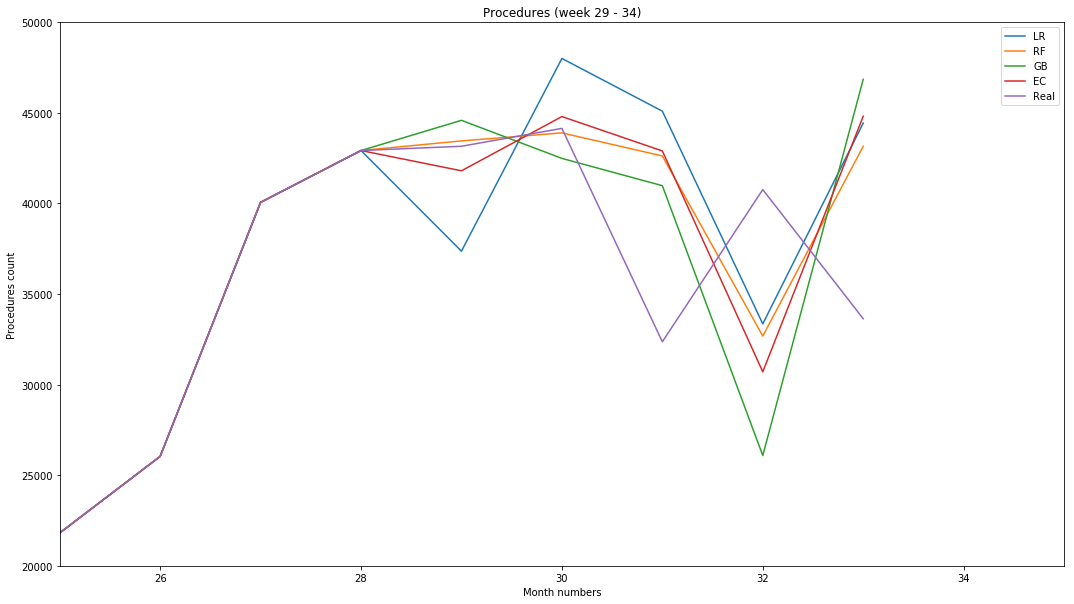

In [106]:
plt.plot(predict_ProcLR24)
plt.plot(predict_ProcRF24)
plt.plot(predict_ProcGB24)
plt.plot(predict_ProcEC24)
plt.plot(proceduresAll)
plt.title(s)
plt.xlabel('Month numbers')
plt.ylabel('Procedures count')
plt.legend(('LR', 'RF', 'GB', 'EC', 'Real'))
plt.xlim(25, 35)
plt.ylim(20000, 50000)

(20000, 60000)

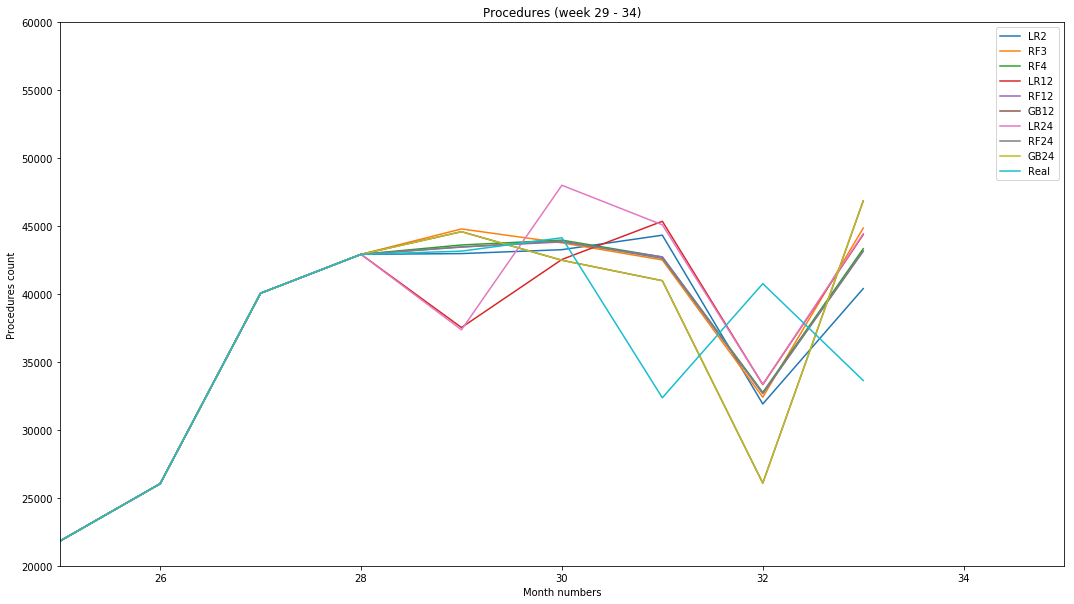

In [107]:
plt.plot(predict_ProcLR2)
plt.plot(predict_ProcRF3)
plt.plot(predict_ProcRF4)
plt.plot(predict_ProcLR12)
plt.plot(predict_ProcRF12)
plt.plot(predict_ProcGB12)
plt.plot(predict_ProcLR24)
plt.plot(predict_ProcRF24)
plt.plot(predict_ProcGB24)
plt.plot(proceduresAll)

plt.title(s)
plt.xlabel('Month numbers')
plt.ylabel('Procedures count')
plt.legend(('LR2', 'RF3', 'RF4', 'LR12', 'RF12', 'GB12', 'LR24', 'RF24', 'GB24', 'Real'))
plt.xlim(25, 35)
plt.ylim(20000, 60000)

In [108]:
print('Mean Error baseline = %.5f' % np.mean(mean_errorB))
print('Mean Abs Error baseline = %.5f' % np.mean(total_errorB))
print('Mean Abs Error baseline persent = %.5f' % np.mean(abs_pr_errorB))
print('Mean Error LR2 = %.5f' % np.mean(mean_errorLR2))
print('Mean Abs Error LR2 = %.5f' % np.mean(total_errorLR2))
print('Mean Abs Error LR2 persent = %.5f' % np.mean(abs_pr_errorLR2))
print('Mean Error RF2 = %.5f' % np.mean(mean_errorRF2))
print('Mean Abs Error RF2 = %.5f' % np.mean(total_errorRF2))
print('Mean Abs Error RF2 persent = %.5f' % np.mean(abs_pr_errorRF2))
print('Mean Error RF3 = %.5f' % np.mean(mean_errorRF3))
print('Mean Abs Error RF3 = %.5f' % np.mean(total_errorRF3))
print('Mean Abs Error RF3 persent = %.5f' % np.mean(abs_pr_errorRF3))
print('Mean Error RF4 = %.5f' % np.mean(mean_errorRF4))
print('Mean Abs Error RF4 = %.5f' % np.mean(total_errorRF4))
print('Mean Abs Error RF4 persent = %.5f' % np.mean(abs_pr_errorRF4))
print('Mean Error RF4_n = %.5f' % np.mean(mean_errorRF4_n))
print('Mean Abs Error RF4_n = %.5f' % np.mean(total_errorRF4_n))
print('Mean Abs Error RF4_n persent = %.5f' % np.mean(abs_pr_errorRF4_n))
print('Mean Error GB4 = %.5f' % np.mean(mean_errorGB4))
print('Mean Abs Error GB4 = %.5f' % np.mean(total_errorGB4))
print('Mean Abs Error GB4 persent = %.5f' % np.mean(abs_pr_errorGB4))
print('Mean Error LR12 = %.5f' % np.mean(mean_errorLR12))
print('Mean Abs Error LR12 = %.5f' % np.mean(total_errorLR12))
print('Mean Abs Error LR12 persent = %.5f' % np.mean(abs_pr_errorLR12))
print('Mean Error = %.5f' % np.mean(mean_errorRF12))
print('Mean Abs Error = %.5f' % np.mean(total_errorRF12))
print('Mean Abs Error persent = %.5f' % np.mean(abs_pr_errorRF12))
print('Mean Error GB12 = %.5f' % np.mean(mean_errorGB12))
print('Mean Abs Error GB12 = %.5f' % np.mean(total_errorGB12))
print('Mean Abs Error GB12 persent = %.5f' % np.mean(abs_pr_errorGB12))
print('Mean Error LR24 = %.5f' % np.mean(mean_errorLR24))
print('Mean Abs Error LR24 = %.5f' % np.mean(total_errorLR24))
print('Mean Abs Error LR24 persent = %.5f' % np.mean(abs_pr_errorLR24))
print('Mean Error = %.5f' % np.mean(mean_errorRF24))
print('Mean Abs Error = %.5f' % np.mean(total_errorRF24))
print('Mean Abs Error persent = %.5f' % np.mean(abs_pr_errorRF24))
print('Mean Error GB24 = %.5f' % np.mean(mean_errorGB24))
print('Mean Abs Error GB24 = %.5f' % np.mean(total_errorGB24))
print('Mean Abs Error GB24 persent = %.5f' % np.mean(abs_pr_errorGB24))

Mean Error baseline = 0.44740
Mean Abs Error baseline = 5704.40000
Mean Abs Error baseline persent = 16.19098
Mean Error LR2 = 1.11154
Mean Abs Error LR2 = 5726.82895
Mean Abs Error LR2 persent = 16.23747
Mean Error RF2 = 0.50190
Mean Abs Error RF2 = 6621.21520
Mean Abs Error RF2 persent = 18.51048
Mean Error RF3 = 0.51567
Mean Abs Error RF3 = 6345.64960
Mean Abs Error RF3 persent = 17.96634
Mean Error RF4 = 0.50941
Mean Abs Error RF4 = 5737.95040
Mean Abs Error RF4 persent = 16.38466
Mean Error RF4_n = 0.42261
Mean Abs Error RF4_n = 6566.60323
Mean Abs Error RF4_n persent = 17.64580
Mean Error GB4 = 0.44861
Mean Abs Error GB4 = 7917.95673
Mean Abs Error GB4 persent = 21.79390
Mean Error LR12 = 1.16694
Mean Abs Error LR12 = 7673.53087
Mean Abs Error LR12 persent = 21.38170
Mean Error = 0.51071
Mean Abs Error = 5721.05520
Mean Abs Error persent = 16.32475
Mean Error GB12 = 0.44861
Mean Abs Error GB12 = 7917.95673
Mean Abs Error GB12 persent = 21.79390
Mean Error LR24 = 1.28922
Mean Abs 

In [35]:
cols = ['RegCode', 'Month', 'Last_Month_Proc', 'Last_Month_Diff',
       'Last-1_Month_Proc', 'Last-1_Month_Diff', 'Last-2_Month_Proc',
       'Last-2_Month_Diff', 'Last-3_Month_Proc', 'Last-3_Month_Diff',
       'Last-4_Month_Proc', 'Last-4_Month_Diff', 'Last-5_Month_Proc',
       'Last-5_Month_Diff', 'Last-6_Month_Proc', 'Last-6_Month_Diff',
       'Last-7_Month_Proc', 'Last-7_Month_Diff', 'Last-8_Month_Proc',
       'Last-8_Month_Diff', 'Last-9_Month_Proc', 'Last-9_Month_Diff',
       'Last-10_Month_Proc', 'Last-10_Month_Diff', 'Last-11_Month_Proc',
       'Last-11_Month_Diff', 'Last-12_Month_Proc', 'Last-12_Month_Diff',
       'Last-13_Month_Proc', 'Last-13_Month_Diff', 'Last-14_Month_Proc',
       'Last-14_Month_Diff', 'Last-15_Month_Proc', 'Last-15_Month_Diff',
       'Last-16_Month_Proc', 'Last-16_Month_Diff', 'Last-17_Month_Proc',
       'Last-17_Month_Diff', 'Last-18_Month_Proc', 'Last-18_Month_Diff',
       'Last-19_Month_Proc', 'Last-19_Month_Diff', 'Last-20_Month_Proc',
       'Last-20_Month_Diff', 'Last-21_Month_Proc', 'Last-21_Month_Diff',
       'Last-22_Month_Proc', 'Last-22_Month_Diff', 'Last-23_Month_Proc',
       'Last-23_Month_Diff', 'Last-24_Month_Proc', 'Last-24_Month_Diff']

In [36]:
%%time
#Заготовка под массив столбцов
c = []
colMeanError =[]
#Переменная под максимальное значение score
minErrorValue=100
colMeanAbsError =[]
bestPredictPorc_er = []
minAbsErrorValue=100
minAbsError=250000000000
bestPredictPorc_AbsEr = []
  
#Запоминаем длинну выборки столбцов - 1 (последний столбец - целевая переменная)
l=len(cols) - 1
#В трех циклах последовательно проходим по столбцам и формируем тройки, для каждой трокий делаем get_dummies для 
#перечислимых переменных, строим модель и вычисляем score.
#В переменных maxValue и bestParams сохраняем значения лучщего score и набор параметров, для которого он получился
bestCols = []
for i in range(0, l, 1):
    for j in range(i+1, l, 1):
        #Проверяем, что у нас нет одинаковых столбцов в выборке
        if cols[i]==cols[j]:
            continue
        c = []
        #Добавляем названия столбцов в выборку    
        c.append(cols[i])
        c.append(cols[j])
        mean_error = []
        total_error = []
        Proc = copy.copy(procedures)
        predict_Proc = copy.copy(procedures)
        abs_pr_error = []
        for Month in range(month_start, month_end):
            train = melt24[melt24['Month'] < Month]
            val = melt24[melt24['Month'] == Month]
            
            #Выделяем столбцы для эксперимента
            xtr, xts = train[c].values, val[c].values
            ytr, yts = train['Proc'].values, val['Proc'].values
                
            mdl = RandomForestRegressor(n_estimators=100, n_jobs=-1, random_state=0)
            mdl.fit(xtr, ytr)
    
            p = mdl.predict(xts)
    
            total_yts=sum(yts)
            total_p=sum(p)
                
            error = rmsle(yts, p)
            abs_error = abs(total_yts-total_p)
            abs_pr = abs_error/total_yts*100

            #print('Month %d - Error %.5f, Real Total %.1f - Predict Total %.1f, Abs Error %.1f, Persent - %.1f' % (month, error, total_yts, total_p, abs_error, abs_pr))
            mean_error.append(error)
            total_error.append(abs_error)
            Proc.append(total_yts)
            predict_Proc.append(total_p)
            abs_pr_error.append(abs_pr)
        MR = np.mean(mean_error)
        TR = np.mean(total_error)
        TRP = np.mean(abs_pr_error)
        print(c)
        print('Mean Error %.5f, Abs Error %.1f, Abs Error Persent - %.1f' % (MR, TR, TRP))
        if MR<minErrorValue:
            minErrorValue=MR
            colMeanError=c
            bestPredictPorc_er = predict_Proc
        if TRP<minAbsErrorValue:
            minAbsErrorValue=TRP
            colMeanAbsError=c
            bestPredictPorc_AbsEr = predict_Proc
        if TR<minAbsError:
            minAbsError=TR
            bestCols=c
            bestPredictPorc_AbsEr = predict_Proc
                

['RegCode', 'Month']
Mean Error 0.43367, Abs Error 4879.6, Abs Error Persent - 13.9
['RegCode', 'Last_Month_Proc']
Mean Error 0.46469, Abs Error 5143.8, Abs Error Persent - 14.8
['RegCode', 'Last_Month_Diff']
Mean Error 0.73709, Abs Error 6569.2, Abs Error Persent - 16.1
['RegCode', 'Last-1_Month_Proc']
Mean Error 0.54989, Abs Error 5151.8, Abs Error Persent - 14.4
['RegCode', 'Last-1_Month_Diff']
Mean Error 0.74296, Abs Error 6197.9, Abs Error Persent - 15.3
['RegCode', 'Last-2_Month_Proc']
Mean Error 0.61814, Abs Error 7196.4, Abs Error Persent - 18.5
['RegCode', 'Last-2_Month_Diff']
Mean Error 0.75419, Abs Error 5289.6, Abs Error Persent - 12.9
['RegCode', 'Last-3_Month_Proc']
Mean Error 0.61814, Abs Error 7196.4, Abs Error Persent - 18.5
['RegCode', 'Last-3_Month_Diff']
Mean Error 0.75419, Abs Error 5289.6, Abs Error Persent - 12.9
['RegCode', 'Last-4_Month_Proc']
Mean Error 0.61814, Abs Error 7196.4, Abs Error Persent - 18.5
['RegCode', 'Last-4_Month_Diff']
Mean Error 0.75419, Abs

['Month', 'Last-18_Month_Proc']
Mean Error 0.81375, Abs Error 10199.1, Abs Error Persent - 28.0
['Month', 'Last-18_Month_Diff']
Mean Error 1.37729, Abs Error 11394.0, Abs Error Persent - 27.5
['Month', 'Last-19_Month_Proc']
Mean Error 0.81375, Abs Error 10199.1, Abs Error Persent - 28.0
['Month', 'Last-19_Month_Diff']
Mean Error 1.37729, Abs Error 11394.0, Abs Error Persent - 27.5
['Month', 'Last-20_Month_Proc']
Mean Error 0.81375, Abs Error 10199.1, Abs Error Persent - 28.0
['Month', 'Last-20_Month_Diff']
Mean Error 1.37729, Abs Error 11394.0, Abs Error Persent - 27.5
['Month', 'Last-21_Month_Proc']
Mean Error 0.63854, Abs Error 8862.3, Abs Error Persent - 22.7
['Month', 'Last-21_Month_Diff']
Mean Error 1.41489, Abs Error 13896.1, Abs Error Persent - 36.7
['Month', 'Last-22_Month_Proc']
Mean Error 0.81375, Abs Error 10199.1, Abs Error Persent - 28.0
['Month', 'Last-22_Month_Diff']
Mean Error 1.37729, Abs Error 11394.0, Abs Error Persent - 27.5
['Month', 'Last-23_Month_Proc']
Mean Erro

['Last_Month_Diff', 'Last-10_Month_Diff']
Mean Error 1.01477, Abs Error 4731.6, Abs Error Persent - 12.7
['Last_Month_Diff', 'Last-11_Month_Proc']
Mean Error 0.54701, Abs Error 5252.9, Abs Error Persent - 14.6
['Last_Month_Diff', 'Last-11_Month_Diff']
Mean Error 0.99328, Abs Error 7391.6, Abs Error Persent - 19.4
['Last_Month_Diff', 'Last-12_Month_Proc']
Mean Error 0.62592, Abs Error 9488.0, Abs Error Persent - 25.1
['Last_Month_Diff', 'Last-12_Month_Diff']
Mean Error 1.01477, Abs Error 4731.6, Abs Error Persent - 12.7
['Last_Month_Diff', 'Last-13_Month_Proc']
Mean Error 0.62592, Abs Error 9488.0, Abs Error Persent - 25.1
['Last_Month_Diff', 'Last-13_Month_Diff']
Mean Error 1.01477, Abs Error 4731.6, Abs Error Persent - 12.7
['Last_Month_Diff', 'Last-14_Month_Proc']
Mean Error 0.62592, Abs Error 9488.0, Abs Error Persent - 25.1
['Last_Month_Diff', 'Last-14_Month_Diff']
Mean Error 1.01477, Abs Error 4731.6, Abs Error Persent - 12.7
['Last_Month_Diff', 'Last-15_Month_Proc']
Mean Error 0.

['Last-1_Month_Diff', 'Last-4_Month_Proc']
Mean Error 0.66108, Abs Error 5086.8, Abs Error Persent - 13.6
['Last-1_Month_Diff', 'Last-4_Month_Diff']
Mean Error 0.99633, Abs Error 5406.5, Abs Error Persent - 13.5
['Last-1_Month_Diff', 'Last-5_Month_Proc']
Mean Error 0.66108, Abs Error 5086.8, Abs Error Persent - 13.6
['Last-1_Month_Diff', 'Last-5_Month_Diff']
Mean Error 0.99633, Abs Error 5406.5, Abs Error Persent - 13.5
['Last-1_Month_Diff', 'Last-6_Month_Proc']
Mean Error 0.66108, Abs Error 5086.8, Abs Error Persent - 13.6
['Last-1_Month_Diff', 'Last-6_Month_Diff']
Mean Error 0.99633, Abs Error 5406.5, Abs Error Persent - 13.5
['Last-1_Month_Diff', 'Last-7_Month_Proc']
Mean Error 0.66108, Abs Error 5086.8, Abs Error Persent - 13.6
['Last-1_Month_Diff', 'Last-7_Month_Diff']
Mean Error 0.99633, Abs Error 5406.5, Abs Error Persent - 13.5
['Last-1_Month_Diff', 'Last-8_Month_Proc']
Mean Error 0.66108, Abs Error 5086.8, Abs Error Persent - 13.6
['Last-1_Month_Diff', 'Last-8_Month_Diff']
Mea

['Last-2_Month_Proc', 'Last-20_Month_Diff']
Mean Error 0.74299, Abs Error 6881.9, Abs Error Persent - 17.7
['Last-2_Month_Proc', 'Last-21_Month_Proc']
Mean Error 0.65113, Abs Error 4311.5, Abs Error Persent - 11.7
['Last-2_Month_Proc', 'Last-21_Month_Diff']
Mean Error 0.66108, Abs Error 5086.8, Abs Error Persent - 13.6
['Last-2_Month_Proc', 'Last-22_Month_Proc']
Mean Error 0.80396, Abs Error 7781.7, Abs Error Persent - 20.7
['Last-2_Month_Proc', 'Last-22_Month_Diff']
Mean Error 0.74299, Abs Error 6881.9, Abs Error Persent - 17.7
['Last-2_Month_Proc', 'Last-23_Month_Proc']
Mean Error 0.80396, Abs Error 7781.7, Abs Error Persent - 20.7
['Last-2_Month_Proc', 'Last-23_Month_Diff']
Mean Error 0.74299, Abs Error 6881.9, Abs Error Persent - 17.7
['Last-2_Month_Proc', 'Last-24_Month_Proc']
Mean Error 0.80396, Abs Error 7781.7, Abs Error Persent - 20.7
['Last-2_Month_Diff', 'Last-3_Month_Proc']
Mean Error 0.74282, Abs Error 6881.7, Abs Error Persent - 17.7
['Last-2_Month_Diff', 'Last-3_Month_Di

['Last-3_Month_Proc', 'Last-16_Month_Diff']
Mean Error 0.74299, Abs Error 6881.9, Abs Error Persent - 17.7
['Last-3_Month_Proc', 'Last-17_Month_Proc']
Mean Error 0.80396, Abs Error 7781.7, Abs Error Persent - 20.7
['Last-3_Month_Proc', 'Last-17_Month_Diff']
Mean Error 0.74299, Abs Error 6881.9, Abs Error Persent - 17.7
['Last-3_Month_Proc', 'Last-18_Month_Proc']
Mean Error 0.80396, Abs Error 7781.7, Abs Error Persent - 20.7
['Last-3_Month_Proc', 'Last-18_Month_Diff']
Mean Error 0.74299, Abs Error 6881.9, Abs Error Persent - 17.7
['Last-3_Month_Proc', 'Last-19_Month_Proc']
Mean Error 0.80396, Abs Error 7781.7, Abs Error Persent - 20.7
['Last-3_Month_Proc', 'Last-19_Month_Diff']
Mean Error 0.74299, Abs Error 6881.9, Abs Error Persent - 17.7
['Last-3_Month_Proc', 'Last-20_Month_Proc']
Mean Error 0.80396, Abs Error 7781.7, Abs Error Persent - 20.7
['Last-3_Month_Proc', 'Last-20_Month_Diff']
Mean Error 0.74299, Abs Error 6881.9, Abs Error Persent - 17.7
['Last-3_Month_Proc', 'Last-21_Month_

['Last-4_Month_Proc', 'Last-14_Month_Diff']
Mean Error 0.74299, Abs Error 6881.9, Abs Error Persent - 17.7
['Last-4_Month_Proc', 'Last-15_Month_Proc']
Mean Error 0.80396, Abs Error 7781.7, Abs Error Persent - 20.7
['Last-4_Month_Proc', 'Last-15_Month_Diff']
Mean Error 0.74299, Abs Error 6881.9, Abs Error Persent - 17.7
['Last-4_Month_Proc', 'Last-16_Month_Proc']
Mean Error 0.80396, Abs Error 7781.7, Abs Error Persent - 20.7
['Last-4_Month_Proc', 'Last-16_Month_Diff']
Mean Error 0.74299, Abs Error 6881.9, Abs Error Persent - 17.7
['Last-4_Month_Proc', 'Last-17_Month_Proc']
Mean Error 0.80396, Abs Error 7781.7, Abs Error Persent - 20.7
['Last-4_Month_Proc', 'Last-17_Month_Diff']
Mean Error 0.74299, Abs Error 6881.9, Abs Error Persent - 17.7
['Last-4_Month_Proc', 'Last-18_Month_Proc']
Mean Error 0.80396, Abs Error 7781.7, Abs Error Persent - 20.7
['Last-4_Month_Proc', 'Last-18_Month_Diff']
Mean Error 0.74299, Abs Error 6881.9, Abs Error Persent - 17.7
['Last-4_Month_Proc', 'Last-19_Month_

['Last-5_Month_Proc', 'Last-14_Month_Diff']
Mean Error 0.74299, Abs Error 6881.9, Abs Error Persent - 17.7
['Last-5_Month_Proc', 'Last-15_Month_Proc']
Mean Error 0.80396, Abs Error 7781.7, Abs Error Persent - 20.7
['Last-5_Month_Proc', 'Last-15_Month_Diff']
Mean Error 0.74299, Abs Error 6881.9, Abs Error Persent - 17.7
['Last-5_Month_Proc', 'Last-16_Month_Proc']
Mean Error 0.80396, Abs Error 7781.7, Abs Error Persent - 20.7
['Last-5_Month_Proc', 'Last-16_Month_Diff']
Mean Error 0.74299, Abs Error 6881.9, Abs Error Persent - 17.7
['Last-5_Month_Proc', 'Last-17_Month_Proc']
Mean Error 0.80396, Abs Error 7781.7, Abs Error Persent - 20.7
['Last-5_Month_Proc', 'Last-17_Month_Diff']
Mean Error 0.74299, Abs Error 6881.9, Abs Error Persent - 17.7
['Last-5_Month_Proc', 'Last-18_Month_Proc']
Mean Error 0.80396, Abs Error 7781.7, Abs Error Persent - 20.7
['Last-5_Month_Proc', 'Last-18_Month_Diff']
Mean Error 0.74299, Abs Error 6881.9, Abs Error Persent - 17.7
['Last-5_Month_Proc', 'Last-19_Month_

['Last-6_Month_Proc', 'Last-16_Month_Diff']
Mean Error 0.74299, Abs Error 6881.9, Abs Error Persent - 17.7
['Last-6_Month_Proc', 'Last-17_Month_Proc']
Mean Error 0.80396, Abs Error 7781.7, Abs Error Persent - 20.7
['Last-6_Month_Proc', 'Last-17_Month_Diff']
Mean Error 0.74299, Abs Error 6881.9, Abs Error Persent - 17.7
['Last-6_Month_Proc', 'Last-18_Month_Proc']
Mean Error 0.80396, Abs Error 7781.7, Abs Error Persent - 20.7
['Last-6_Month_Proc', 'Last-18_Month_Diff']
Mean Error 0.74299, Abs Error 6881.9, Abs Error Persent - 17.7
['Last-6_Month_Proc', 'Last-19_Month_Proc']
Mean Error 0.80396, Abs Error 7781.7, Abs Error Persent - 20.7
['Last-6_Month_Proc', 'Last-19_Month_Diff']
Mean Error 0.74299, Abs Error 6881.9, Abs Error Persent - 17.7
['Last-6_Month_Proc', 'Last-20_Month_Proc']
Mean Error 0.80396, Abs Error 7781.7, Abs Error Persent - 20.7
['Last-6_Month_Proc', 'Last-20_Month_Diff']
Mean Error 0.74299, Abs Error 6881.9, Abs Error Persent - 17.7
['Last-6_Month_Proc', 'Last-21_Month_

['Last-7_Month_Proc', 'Last-20_Month_Diff']
Mean Error 0.74299, Abs Error 6881.9, Abs Error Persent - 17.7
['Last-7_Month_Proc', 'Last-21_Month_Proc']
Mean Error 0.65113, Abs Error 4311.5, Abs Error Persent - 11.7
['Last-7_Month_Proc', 'Last-21_Month_Diff']
Mean Error 0.66108, Abs Error 5086.8, Abs Error Persent - 13.6
['Last-7_Month_Proc', 'Last-22_Month_Proc']
Mean Error 0.80396, Abs Error 7781.7, Abs Error Persent - 20.7
['Last-7_Month_Proc', 'Last-22_Month_Diff']
Mean Error 0.74299, Abs Error 6881.9, Abs Error Persent - 17.7
['Last-7_Month_Proc', 'Last-23_Month_Proc']
Mean Error 0.80396, Abs Error 7781.7, Abs Error Persent - 20.7
['Last-7_Month_Proc', 'Last-23_Month_Diff']
Mean Error 0.74299, Abs Error 6881.9, Abs Error Persent - 17.7
['Last-7_Month_Proc', 'Last-24_Month_Proc']
Mean Error 0.80396, Abs Error 7781.7, Abs Error Persent - 20.7
['Last-7_Month_Diff', 'Last-8_Month_Proc']
Mean Error 0.74282, Abs Error 6881.7, Abs Error Persent - 17.7
['Last-7_Month_Diff', 'Last-8_Month_Di

['Last-8_Month_Diff', 'Last-11_Month_Proc']
Mean Error 0.59824, Abs Error 4584.5, Abs Error Persent - 11.8
['Last-8_Month_Diff', 'Last-11_Month_Diff']
Mean Error 0.99635, Abs Error 5399.8, Abs Error Persent - 13.5
['Last-8_Month_Diff', 'Last-12_Month_Proc']
Mean Error 0.74282, Abs Error 6881.7, Abs Error Persent - 17.7
['Last-8_Month_Diff', 'Last-12_Month_Diff']
Mean Error 1.51214, Abs Error 9088.8, Abs Error Persent - 23.1
['Last-8_Month_Diff', 'Last-13_Month_Proc']
Mean Error 0.74282, Abs Error 6881.7, Abs Error Persent - 17.7
['Last-8_Month_Diff', 'Last-13_Month_Diff']
Mean Error 1.51214, Abs Error 9088.8, Abs Error Persent - 23.1
['Last-8_Month_Diff', 'Last-14_Month_Proc']
Mean Error 0.74282, Abs Error 6881.7, Abs Error Persent - 17.7
['Last-8_Month_Diff', 'Last-14_Month_Diff']
Mean Error 1.51214, Abs Error 9088.8, Abs Error Persent - 23.1
['Last-8_Month_Diff', 'Last-15_Month_Proc']
Mean Error 0.74282, Abs Error 6881.7, Abs Error Persent - 17.7
['Last-8_Month_Diff', 'Last-15_Month_

['Last-9_Month_Diff', 'Last-20_Month_Proc']
Mean Error 0.74282, Abs Error 6881.7, Abs Error Persent - 17.7
['Last-9_Month_Diff', 'Last-20_Month_Diff']
Mean Error 1.51214, Abs Error 9088.8, Abs Error Persent - 23.1
['Last-9_Month_Diff', 'Last-21_Month_Proc']
Mean Error 0.59824, Abs Error 4584.5, Abs Error Persent - 11.8
['Last-9_Month_Diff', 'Last-21_Month_Diff']
Mean Error 0.99635, Abs Error 5399.8, Abs Error Persent - 13.5
['Last-9_Month_Diff', 'Last-22_Month_Proc']
Mean Error 0.74282, Abs Error 6881.7, Abs Error Persent - 17.7
['Last-9_Month_Diff', 'Last-22_Month_Diff']
Mean Error 1.51214, Abs Error 9088.8, Abs Error Persent - 23.1
['Last-9_Month_Diff', 'Last-23_Month_Proc']
Mean Error 0.74282, Abs Error 6881.7, Abs Error Persent - 17.7
['Last-9_Month_Diff', 'Last-23_Month_Diff']
Mean Error 1.51214, Abs Error 9088.8, Abs Error Persent - 23.1
['Last-9_Month_Diff', 'Last-24_Month_Proc']
Mean Error 0.74282, Abs Error 6881.7, Abs Error Persent - 17.7
['Last-10_Month_Proc', 'Last-10_Month

['Last-11_Month_Proc', 'Last-17_Month_Diff']
Mean Error 0.59755, Abs Error 4578.4, Abs Error Persent - 11.8
['Last-11_Month_Proc', 'Last-18_Month_Proc']
Mean Error 0.65113, Abs Error 4311.5, Abs Error Persent - 11.7
['Last-11_Month_Proc', 'Last-18_Month_Diff']
Mean Error 0.59755, Abs Error 4578.4, Abs Error Persent - 11.8
['Last-11_Month_Proc', 'Last-19_Month_Proc']
Mean Error 0.65113, Abs Error 4311.5, Abs Error Persent - 11.7
['Last-11_Month_Proc', 'Last-19_Month_Diff']
Mean Error 0.59755, Abs Error 4578.4, Abs Error Persent - 11.8
['Last-11_Month_Proc', 'Last-20_Month_Proc']
Mean Error 0.65113, Abs Error 4311.5, Abs Error Persent - 11.7
['Last-11_Month_Proc', 'Last-20_Month_Diff']
Mean Error 0.59755, Abs Error 4578.4, Abs Error Persent - 11.8
['Last-11_Month_Proc', 'Last-21_Month_Proc']
Mean Error 0.68428, Abs Error 3265.6, Abs Error Persent - 9.4
['Last-11_Month_Proc', 'Last-21_Month_Diff']
Mean Error 0.64184, Abs Error 3531.6, Abs Error Persent - 9.7
['Last-11_Month_Proc', 'Last-2

['Last-12_Month_Diff', 'Last-19_Month_Diff']
Mean Error 1.51214, Abs Error 9088.8, Abs Error Persent - 23.1
['Last-12_Month_Diff', 'Last-20_Month_Proc']
Mean Error 0.74282, Abs Error 6881.7, Abs Error Persent - 17.7
['Last-12_Month_Diff', 'Last-20_Month_Diff']
Mean Error 1.51214, Abs Error 9088.8, Abs Error Persent - 23.1
['Last-12_Month_Diff', 'Last-21_Month_Proc']
Mean Error 0.59824, Abs Error 4584.5, Abs Error Persent - 11.8
['Last-12_Month_Diff', 'Last-21_Month_Diff']
Mean Error 0.99635, Abs Error 5399.8, Abs Error Persent - 13.5
['Last-12_Month_Diff', 'Last-22_Month_Proc']
Mean Error 0.74282, Abs Error 6881.7, Abs Error Persent - 17.7
['Last-12_Month_Diff', 'Last-22_Month_Diff']
Mean Error 1.51214, Abs Error 9088.8, Abs Error Persent - 23.1
['Last-12_Month_Diff', 'Last-23_Month_Proc']
Mean Error 0.74282, Abs Error 6881.7, Abs Error Persent - 17.7
['Last-12_Month_Diff', 'Last-23_Month_Diff']
Mean Error 1.51214, Abs Error 9088.8, Abs Error Persent - 23.1
['Last-12_Month_Diff', 'Last

['Last-14_Month_Diff', 'Last-16_Month_Diff']
Mean Error 1.51214, Abs Error 9088.8, Abs Error Persent - 23.1
['Last-14_Month_Diff', 'Last-17_Month_Proc']
Mean Error 0.74282, Abs Error 6881.7, Abs Error Persent - 17.7
['Last-14_Month_Diff', 'Last-17_Month_Diff']
Mean Error 1.51214, Abs Error 9088.8, Abs Error Persent - 23.1
['Last-14_Month_Diff', 'Last-18_Month_Proc']
Mean Error 0.74282, Abs Error 6881.7, Abs Error Persent - 17.7
['Last-14_Month_Diff', 'Last-18_Month_Diff']
Mean Error 1.51214, Abs Error 9088.8, Abs Error Persent - 23.1
['Last-14_Month_Diff', 'Last-19_Month_Proc']
Mean Error 0.74282, Abs Error 6881.7, Abs Error Persent - 17.7
['Last-14_Month_Diff', 'Last-19_Month_Diff']
Mean Error 1.51214, Abs Error 9088.8, Abs Error Persent - 23.1
['Last-14_Month_Diff', 'Last-20_Month_Proc']
Mean Error 0.74282, Abs Error 6881.7, Abs Error Persent - 17.7
['Last-14_Month_Diff', 'Last-20_Month_Diff']
Mean Error 1.51214, Abs Error 9088.8, Abs Error Persent - 23.1
['Last-14_Month_Diff', 'Last

['Last-16_Month_Diff', 'Last-21_Month_Diff']
Mean Error 0.99635, Abs Error 5399.8, Abs Error Persent - 13.5
['Last-16_Month_Diff', 'Last-22_Month_Proc']
Mean Error 0.74282, Abs Error 6881.7, Abs Error Persent - 17.7
['Last-16_Month_Diff', 'Last-22_Month_Diff']
Mean Error 1.51214, Abs Error 9088.8, Abs Error Persent - 23.1
['Last-16_Month_Diff', 'Last-23_Month_Proc']
Mean Error 0.74282, Abs Error 6881.7, Abs Error Persent - 17.7
['Last-16_Month_Diff', 'Last-23_Month_Diff']
Mean Error 1.51214, Abs Error 9088.8, Abs Error Persent - 23.1
['Last-16_Month_Diff', 'Last-24_Month_Proc']
Mean Error 0.74282, Abs Error 6881.7, Abs Error Persent - 17.7
['Last-17_Month_Proc', 'Last-17_Month_Diff']
Mean Error 0.74299, Abs Error 6881.9, Abs Error Persent - 17.7
['Last-17_Month_Proc', 'Last-18_Month_Proc']
Mean Error 0.80396, Abs Error 7781.7, Abs Error Persent - 20.7
['Last-17_Month_Proc', 'Last-18_Month_Diff']
Mean Error 0.74299, Abs Error 6881.9, Abs Error Persent - 17.7
['Last-17_Month_Proc', 'Last

['Last-20_Month_Proc', 'Last-21_Month_Proc']
Mean Error 0.65113, Abs Error 4311.5, Abs Error Persent - 11.7
['Last-20_Month_Proc', 'Last-21_Month_Diff']
Mean Error 0.66108, Abs Error 5086.8, Abs Error Persent - 13.6
['Last-20_Month_Proc', 'Last-22_Month_Proc']
Mean Error 0.80396, Abs Error 7781.7, Abs Error Persent - 20.7
['Last-20_Month_Proc', 'Last-22_Month_Diff']
Mean Error 0.74299, Abs Error 6881.9, Abs Error Persent - 17.7
['Last-20_Month_Proc', 'Last-23_Month_Proc']
Mean Error 0.80396, Abs Error 7781.7, Abs Error Persent - 20.7
['Last-20_Month_Proc', 'Last-23_Month_Diff']
Mean Error 0.74299, Abs Error 6881.9, Abs Error Persent - 17.7
['Last-20_Month_Proc', 'Last-24_Month_Proc']
Mean Error 0.80396, Abs Error 7781.7, Abs Error Persent - 20.7
['Last-20_Month_Diff', 'Last-21_Month_Proc']
Mean Error 0.59824, Abs Error 4584.5, Abs Error Persent - 11.8
['Last-20_Month_Diff', 'Last-21_Month_Diff']
Mean Error 0.99635, Abs Error 5399.8, Abs Error Persent - 13.5
['Last-20_Month_Diff', 'Last

In [37]:
print (minErrorValue)
print(colMeanError)
print(minAbsErrorValue)
print(colMeanAbsError)
print(minAbsError)
print(bestCols)

0.43367290715789925
['RegCode', 'Month']
9.410645642861713
['Last-1_Month_Proc', 'Last-11_Month_Proc']
3265.6012630491737
['Last-1_Month_Proc', 'Last-11_Month_Proc']


In [38]:
k = copy.copy(bestCols)
print(bestCols)

['Last-1_Month_Proc', 'Last-11_Month_Proc']


In [39]:
%%time
k = copy.copy(colMeanError)
for j in range(0, l, 1):
    #Проверяем, что у нас нет одинаковых столбцов в выборке
    c = copy.copy(k)
    if cols[j] in c:
        continue
    c.append(cols[j])
    mean_error = []
    total_error = []
    Proc = copy.copy(procedures)
    predict_Proc = copy.copy(procedures)
    abs_pr_error = []
    for Month in range(month_start, month_end):
        train = melt24[melt24['Month'] < Month]
        val = melt24[melt24['Month'] == Month]
            
        #Выделяем столбцы для эксперимента
        xtr, xts = train[c].values, val[c].values
        ytr, yts = train['Proc'].values, val['Proc'].values
                
        mdl = RandomForestRegressor(n_estimators=100, n_jobs=-1, random_state=0)
        mdl.fit(xtr, ytr)
    
        p = mdl.predict(xts)
    
        total_yts=sum(yts)
        total_p=sum(p)
                
        error = rmsle(yts, p)
        abs_error = abs(total_yts-total_p)
        abs_pr = abs_error/total_yts*100

        #print('Month %d - Error %.5f, Real Total %.1f - Predict Total %.1f, Abs Error %.1f, Persent - %.1f' % (month, error, total_yts, total_p, abs_error, abs_pr))
        mean_error.append(error)
        total_error.append(abs_error)
        Proc.append(total_yts)
        predict_Proc.append(total_p)
        abs_pr_error.append(abs_pr)
    MR = np.mean(mean_error)
    TR = np.mean(total_error)
    TRP = np.mean(abs_pr_error)
    print(c)
    print('Mean Error %.5f, Abs Error %.1f, Abs Error Persent - %.1f' % (MR, TR, TRP))
    if MR<minErrorValue:
        minErrorValue=MR
        colMeanError=c
        bestPredictPorc_er = Proc
    if TRP<minAbsErrorValue:
        minAbsErrorValue=TRP
        colMeanAbsError=c
        bestPredictPorc_AbsEr = Proc
    if TR<minAbsError:
        minAbsError=TR
        bestCols=c
        bestPredictPorc_AbsEr = Proc

['RegCode', 'Month', 'Last_Month_Proc']
Mean Error 0.50451, Abs Error 7945.5, Abs Error Persent - 22.0
['RegCode', 'Month', 'Last_Month_Diff']
Mean Error 0.98435, Abs Error 11084.7, Abs Error Persent - 30.7
['RegCode', 'Month', 'Last-1_Month_Proc']
Mean Error 0.62875, Abs Error 8770.9, Abs Error Persent - 23.4
['RegCode', 'Month', 'Last-1_Month_Diff']
Mean Error 0.99905, Abs Error 8005.5, Abs Error Persent - 20.7
['RegCode', 'Month', 'Last-2_Month_Proc']
Mean Error 0.75379, Abs Error 8252.2, Abs Error Persent - 23.5
['RegCode', 'Month', 'Last-2_Month_Diff']
Mean Error 1.03638, Abs Error 7261.5, Abs Error Persent - 18.5
['RegCode', 'Month', 'Last-3_Month_Proc']
Mean Error 0.75379, Abs Error 8252.2, Abs Error Persent - 23.5
['RegCode', 'Month', 'Last-3_Month_Diff']
Mean Error 1.03638, Abs Error 7261.5, Abs Error Persent - 18.5
['RegCode', 'Month', 'Last-4_Month_Proc']
Mean Error 0.75379, Abs Error 8252.2, Abs Error Persent - 23.5
['RegCode', 'Month', 'Last-4_Month_Diff']
Mean Error 1.036

In [40]:
print (minErrorValue)
print(colMeanError)
print(minAbsErrorValue)
print(colMeanAbsError)
print(minAbsError)
print(bestCols)

0.43367290715789925
['RegCode', 'Month']
9.410645642861713
['Last-1_Month_Proc', 'Last-11_Month_Proc']
3265.6012630491737
['Last-1_Month_Proc', 'Last-11_Month_Proc']


In [41]:
%%time
k = copy.copy(bestCols)
for j in range(0, l, 1):
    #Проверяем, что у нас нет одинаковых столбцов в выборке
    c = copy.copy(k)
    if cols[j] in c:
        continue
    c.append(cols[j])
    mean_error = []
    total_error = []
    Proc = copy.copy(procedures)
    predict_Proc = copy.copy(procedures)
    abs_pr_error = []
    for Month in range(month_start, month_end):
        train = melt24[melt24['Month'] < Month]
        val = melt24[melt24['Month'] == Month]
            
        #Выделяем столбцы для эксперимента
        xtr, xts = train[c].values, val[c].values
        ytr, yts = train['Proc'].values, val['Proc'].values
                
        mdl = RandomForestRegressor(n_estimators=100, n_jobs=-1, random_state=0)
        mdl.fit(xtr, ytr)
    
        p = mdl.predict(xts)
    
        total_yts=sum(yts)
        total_p=sum(p)
                
        error = rmsle(yts, p)
        abs_error = abs(total_yts-total_p)
        abs_pr = abs_error/total_yts*100

        #print('Month %d - Error %.5f, Real Total %.1f - Predict Total %.1f, Abs Error %.1f, Persent - %.1f' % (month, error, total_yts, total_p, abs_error, abs_pr))
        mean_error.append(error)
        total_error.append(abs_error)
        Proc.append(total_yts)
        predict_Proc.append(total_p)
        abs_pr_error.append(abs_pr)
    MR = np.mean(mean_error)
    TR = np.mean(total_error)
    TRP = np.mean(abs_pr_error)
    print(c)
    print('Mean Error %.5f, Abs Error %.1f, Abs Error Persent - %.1f' % (MR, TR, TRP))
    if MR<minErrorValue:
        minErrorValue=MR
        colMeanError=c
        bestPredictPorc_er = predict_Proc
    if TRP<minAbsErrorValue:
        minAbsErrorValue=TRP
        colMeanAbsError=c
        bestPredictPorc_AbsEr = predict_Proc
    if TR<minAbsError:
        minAbsError=TR
        bestCols=c
        bestPredictPorc_AbsEr = predict_Proc

['Last-1_Month_Proc', 'Last-11_Month_Proc', 'RegCode']
Mean Error 0.54997, Abs Error 5152.2, Abs Error Persent - 14.4
['Last-1_Month_Proc', 'Last-11_Month_Proc', 'Month']
Mean Error 0.64052, Abs Error 8928.6, Abs Error Persent - 22.8
['Last-1_Month_Proc', 'Last-11_Month_Proc', 'Last_Month_Proc']
Mean Error 0.52171, Abs Error 6075.5, Abs Error Persent - 17.1
['Last-1_Month_Proc', 'Last-11_Month_Proc', 'Last_Month_Diff']
Mean Error 0.54634, Abs Error 5254.2, Abs Error Persent - 14.6
['Last-1_Month_Proc', 'Last-11_Month_Proc', 'Last-1_Month_Diff']
Mean Error 0.64031, Abs Error 3600.0, Abs Error Persent - 9.8
['Last-1_Month_Proc', 'Last-11_Month_Proc', 'Last-2_Month_Proc']
Mean Error 0.65023, Abs Error 4141.5, Abs Error Persent - 11.3
['Last-1_Month_Proc', 'Last-11_Month_Proc', 'Last-2_Month_Diff']
Mean Error 0.59702, Abs Error 4661.3, Abs Error Persent - 12.0
['Last-1_Month_Proc', 'Last-11_Month_Proc', 'Last-3_Month_Proc']
Mean Error 0.65023, Abs Error 4141.5, Abs Error Persent - 11.3
['L

In [42]:
print (minErrorValue)
print(colMeanError)
print(minAbsErrorValue)
print(colMeanAbsError)
print(minAbsError)
print(bestCols)

0.43367290715789925
['RegCode', 'Month']
9.410645642861713
['Last-1_Month_Proc', 'Last-11_Month_Proc']
3265.6012630491737
['Last-1_Month_Proc', 'Last-11_Month_Proc']


In [43]:
%%time
k = copy.copy(bestCols)
for j in range(0, l, 1):
    #Проверяем, что у нас нет одинаковых столбцов в выборке
    c = copy.copy(k)
    if cols[j] in c:
        continue
    c.append(cols[j])
    mean_error = []
    total_error = []
    Proc = copy.copy(procedures)
    predict_Proc = copy.copy(procedures)
    abs_pr_error = []
    for Month in range(month_start, month_end):
        train = melt24[melt24['Month'] < Month]
        val = melt24[melt24['Month'] == Month]
            
        #Выделяем столбцы для эксперимента
        xtr, xts = train[c].values, val[c].values
        ytr, yts = train['Proc'].values, val['Proc'].values
                
        mdl = RandomForestRegressor(n_estimators=100, n_jobs=-1, random_state=0)
        mdl.fit(xtr, ytr)
    
        p = mdl.predict(xts)
    
        total_yts=sum(yts)
        total_p=sum(p)
                
        error = rmsle(yts, p)
        abs_error = abs(total_yts-total_p)
        abs_pr = abs_error/total_yts*100

        #print('Month %d - Error %.5f, Real Total %.1f - Predict Total %.1f, Abs Error %.1f, Persent - %.1f' % (month, error, total_yts, total_p, abs_error, abs_pr))
        mean_error.append(error)
        total_error.append(abs_error)
        Proc.append(total_yts)
        predict_Proc.append(total_p)
        abs_pr_error.append(abs_pr)
    MR = np.mean(mean_error)
    TR = np.mean(total_error)
    TRP = np.mean(abs_pr_error)
    print(c)
    print('Mean Error %.5f, Abs Error %.1f, Abs Error Persent - %.1f' % (MR, TR, TRP))
    if MR<minErrorValue:
        minErrorValue=MR
        colMeanError=c
        bestPredictPorc_er = predict_Proc
    if TRP<minAbsErrorValue:
        minAbsErrorValue=TRP
        colMeanAbsError=c
        bestPredictPorc_AbsEr = predict_Proc
    if TR<minAbsError:
        minAbsError=TR
        bestCols=c
        bestPredictPorc_AbsEr = predict_Proc

['Last-1_Month_Proc', 'Last-11_Month_Proc', 'RegCode']
Mean Error 0.54997, Abs Error 5152.2, Abs Error Persent - 14.4
['Last-1_Month_Proc', 'Last-11_Month_Proc', 'Month']
Mean Error 0.64052, Abs Error 8928.6, Abs Error Persent - 22.8
['Last-1_Month_Proc', 'Last-11_Month_Proc', 'Last_Month_Proc']
Mean Error 0.52171, Abs Error 6075.5, Abs Error Persent - 17.1
['Last-1_Month_Proc', 'Last-11_Month_Proc', 'Last_Month_Diff']
Mean Error 0.54634, Abs Error 5254.2, Abs Error Persent - 14.6
['Last-1_Month_Proc', 'Last-11_Month_Proc', 'Last-1_Month_Diff']
Mean Error 0.64031, Abs Error 3600.0, Abs Error Persent - 9.8
['Last-1_Month_Proc', 'Last-11_Month_Proc', 'Last-2_Month_Proc']
Mean Error 0.65023, Abs Error 4141.5, Abs Error Persent - 11.3
['Last-1_Month_Proc', 'Last-11_Month_Proc', 'Last-2_Month_Diff']
Mean Error 0.59702, Abs Error 4661.3, Abs Error Persent - 12.0
['Last-1_Month_Proc', 'Last-11_Month_Proc', 'Last-3_Month_Proc']
Mean Error 0.65023, Abs Error 4141.5, Abs Error Persent - 11.3
['L

In [109]:
%%time
#Проверяем, что у нас нет одинаковых столбцов в выборке
c =['RegCode', 'Month']
mean_error = []
total_error = []
Proc = copy.copy(procedures)
predict_ProcME = copy.copy(procedures)
abs_pr_error = []
for Month in range(month_start, month_end):
    train = melt24[melt24['Month'] < Month]
    val = melt24[melt24['Month'] == Month]
            
    #Выделяем столбцы для эксперимента
    xtr, xts = train[c].values, val[c].values
    ytr, yts = train['Proc'].values, val['Proc'].values
                
    mdl = RandomForestRegressor(n_estimators=100, n_jobs=-1, random_state=0)
    mdl.fit(xtr, ytr)
    
    p = mdl.predict(xts)
    
    total_yts=sum(yts)
    total_p=sum(p)
                
    error = rmsle(yts, p)
    abs_error = abs(total_yts-total_p)
    abs_pr = abs_error/total_yts*100

    #print('Month %d - Error %.5f, Real Total %.1f - Predict Total %.1f, Abs Error %.1f, Persent - %.1f' % (month, error, total_yts, total_p, abs_error, abs_pr))
    mean_error.append(error)
    total_error.append(abs_error)
    Proc.append(total_yts)
    predict_ProcME.append(total_p)
    abs_pr_error.append(abs_pr)
MR = np.mean(mean_error)
TR = np.mean(total_error)
TRP = np.mean(abs_pr_error)
print(c)
print('Mean Error %.5f, Abs Error %.1f, Abs Error Persent - %.1f' % (MR, TR, TRP))

['RegCode', 'Month']
Mean Error 0.43367, Abs Error 4879.6, Abs Error Persent - 13.9
Wall time: 2.14 s


In [110]:
%%time
#Проверяем, что у нас нет одинаковых столбцов в выборке
c =['Last-1_Month_Proc', 'Last-11_Month_Proc']
mean_error = []
total_error = []
Proc = copy.copy(procedures)
predict_ProcMAE = copy.copy(procedures)
abs_pr_error = []
for Month in range(month_start, month_end):
    train = melt24[melt24['Month'] < Month]
    val = melt24[melt24['Month'] == Month]
            
    #Выделяем столбцы для эксперимента
    xtr, xts = train[c].values, val[c].values
    ytr, yts = train['Proc'].values, val['Proc'].values
                
    mdl = RandomForestRegressor(n_estimators=100, n_jobs=-1, random_state=0)
    mdl.fit(xtr, ytr)
    
    p = mdl.predict(xts)
    
    total_yts=sum(yts)
    total_p=sum(p)
                
    error = rmsle(yts, p)
    abs_error = abs(total_yts-total_p)
    abs_pr = abs_error/total_yts*100

    #print('Month %d - Error %.5f, Real Total %.1f - Predict Total %.1f, Abs Error %.1f, Persent - %.1f' % (month, error, total_yts, total_p, abs_error, abs_pr))
    mean_error.append(error)
    total_error.append(abs_error)
    Proc.append(total_yts)
    predict_ProcMAE.append(total_p)
    abs_pr_error.append(abs_pr)
MR = np.mean(mean_error)
TR = np.mean(total_error)
TRP = np.mean(abs_pr_error)
print(c)
print('Mean Error %.5f, Abs Error %.1f, Abs Error Persent - %.1f' % (MR, TR, TRP))

['Last-1_Month_Proc', 'Last-11_Month_Proc']
Mean Error 0.68428, Abs Error 3265.6, Abs Error Persent - 9.4
Wall time: 2.04 s


In [44]:
print (minErrorValue)
print(colMeanError)
print(minAbsErrorValue)
print(colMeanAbsError)
print(minAbsError)
print(bestCols)

0.43367290715789925
['RegCode', 'Month']
9.410645642861713
['Last-1_Month_Proc', 'Last-11_Month_Proc']
3265.6012630491737
['Last-1_Month_Proc', 'Last-11_Month_Proc']


(20000, 70000)

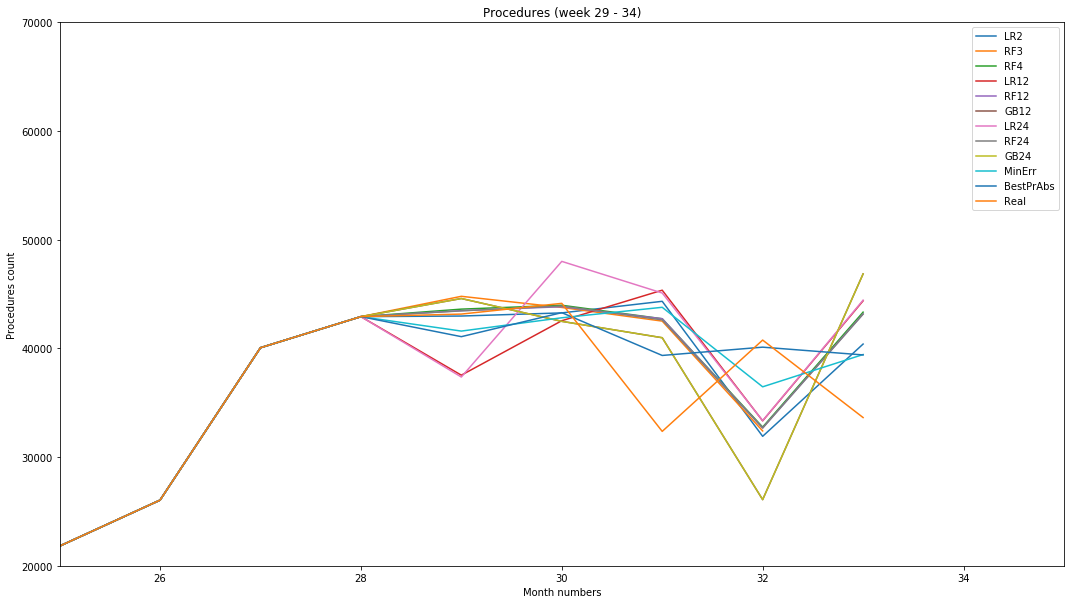

In [45]:
plt.plot(predict_ProcLR2)
plt.plot(predict_ProcRF3)
plt.plot(predict_ProcRF4)
plt.plot(predict_ProcLR12)
plt.plot(predict_ProcRF12)
plt.plot(predict_ProcGB12)
plt.plot(predict_ProcLR24)
plt.plot(predict_ProcRF24)
plt.plot(predict_ProcGB24)
plt.plot(bestPredictPorc_er)
plt.plot(bestPredictPorc_AbsEr)
plt.plot(proceduresAll)

plt.title(s)
plt.xlabel('Month numbers')
plt.ylabel('Procedures count')
plt.legend(('LR2', 'RF3', 'RF4', 'LR12', 'RF12', 'GB12', 'LR24', 'RF24', 'GB24', 'MinErr', 'BestPrAbs', 'Real'))
plt.xlim(25, 35)
plt.ylim(20000, 70000)

In [111]:
#Импортируем Plotly
from plotly.offline import init_notebook_mode, iplot
import plotly
import plotly.graph_objs as go

init_notebook_mode(connected=True)

In [118]:
B = pd.DataFrame({'B': predict_ProcB})
LR2 = pd.DataFrame({'LR2': predict_ProcLR2})
RF3 = pd.DataFrame({'RF3': predict_ProcRF3})
RF4 = pd.DataFrame({'RF4': predict_ProcRF4})
LR12 = pd.DataFrame({'LR12': predict_ProcLR12})
RF12 = pd.DataFrame({'RF12': predict_ProcRF12})
GB12 = pd.DataFrame({'GB12': predict_ProcGB12})
LR24 = pd.DataFrame({'LR24': predict_ProcLR24})
RF24 = pd.DataFrame({'RF24': predict_ProcRF24})
GB24 = pd.DataFrame({'GB24': predict_ProcGB24})

MRMSLE = pd.DataFrame({'MRMSLE': predict_ProcME})
MAE = pd.DataFrame({'MAE': predict_ProcMAE})
REAL = pd.DataFrame({'REAL': proceduresAll})

In [119]:
B.reset_index(inplace=True)
LR2.reset_index(inplace=True)
RF3.reset_index(inplace=True)
RF4.reset_index(inplace=True)
LR12.reset_index(inplace=True)
RF12.reset_index(inplace=True)
GB12.reset_index(inplace=True)
LR24.reset_index(inplace=True)
RF24.reset_index(inplace=True)
GB24.reset_index(inplace=True)
MRMSLE.reset_index(inplace=True)
MAE.reset_index(inplace=True)
REAL.reset_index(inplace=True)

In [120]:
LR2=LR2.merge( B, how = 'inner', left_on = 'index', right_on = 'index' )
LR2=LR2.merge( RF3, how = 'inner', left_on = 'index', right_on = 'index' )
LR2=LR2.merge( RF4, how = 'inner', left_on = 'index', right_on = 'index' )
LR2=LR2.merge( LR12, how = 'inner', left_on = 'index', right_on = 'index' )
LR2=LR2.merge( RF12, how = 'inner', left_on = 'index', right_on = 'index' )
LR2=LR2.merge( GB12, how = 'inner', left_on = 'index', right_on = 'index' )
LR2=LR2.merge( LR24, how = 'inner', left_on = 'index', right_on = 'index' )
LR2=LR2.merge( RF24, how = 'inner', left_on = 'index', right_on = 'index' )
LR2=LR2.merge( GB24, how = 'inner', left_on = 'index', right_on = 'index' )
LR2=LR2.merge( MRMSLE, how = 'inner', left_on = 'index', right_on = 'index' )
LR2=LR2.merge( MAE, how = 'inner', left_on = 'index', right_on = 'index' )
LR2=LR2.merge( REAL, how = 'inner', left_on = 'index', right_on = 'index' )


In [121]:
LR2

,index,LR2,B,RF3,RF4,LR12,RF12,GB12,LR24,RF24,GB24,MRMSLE,MAE,REAL
0,0,0.000000,0.0,0.000,0.000,0.000000,0.000,0.000000,0.000000,0.000,0.000000,0.00,0.000000,0
1,1,3423.000000,3423.0,3423.000,3423.000,3423.000000,3423.000,3423.000000,3423.000000,3423.000,3423.000000,3423.00,3423.000000,3423
2,2,27353.000000,27353.0,27353.000,27353.000,27353.000000,27353.000,27353.000000,27353.000000,27353.000,27353.000000,27353.00,27353.000000,27353
3,3,32402.000000,32402.0,32402.000,32402.000,32402.000000,32402.000,32402.000000,32402.000000,32402.000,32402.000000,32402.00,32402.000000,32402
4,4,36649.000000,36649.0,36649.000,36649.000,36649.000000,36649.000,36649.000000,36649.000000,36649.000,36649.000000,36649.00,36649.000000,36649
5,5,35585.000000,35585.0,35585.000,35585.000,35585.000000,35585.000,35585.000000,35585.000000,35585.000,35585.000000,35585.00,35585.000000,35585
6,6,41272.000000,41272.0,41272.000,41272.000,41272.000000,41272.000,41272.000000,41272.000000,41272.000,41272.000000,41272.00,41272.000000,41272
7,7,29526.000000,29526.0,29526.000,29526.000,29526.000000,29526.000,29526.000000,29526.000000,29526.000,29526.000000,29526.00,29526.000000,29526
8,8,33028.000000,33028.0,33028.000,33028.000,33028.000000,33028.000,33028.000000,33028.000000,33028.000,33028.000000,33028.00,33028.000000,33028
9,9,30259.000000,30259.0,30259.000,30259.000,30259.000000,30259.000,30259.000000,30259.000000,30259.000,30259.000000,30259.00,30259.000000,30259


In [122]:
LR2 = LR2.tail(10)

In [123]:
#Строим графики
trace0 = go.Scatter(
    x=LR2.index,
    y=LR2.LR2,
    name='LR2'
)

trace1 = go.Scatter(
    x=LR2.index,
    y=LR2.RF3,
    name='RF3'
)

trace2 = go.Scatter(
    x=LR2.index,
    y=LR2.RF4,
    name='RF4'
)

trace3 = go.Scatter(
    x=LR2.index,
    y=LR2.LR12,
    name='LR12'
)

trace4 = go.Scatter(
    x=LR2.index,
    y=LR2.RF12,
    name='RF12'
)

trace5 = go.Scatter(
    x=LR2.index,
    y=LR2.GB12,
    name='GB12'
)
trace6 = go.Scatter(
    x=LR2.index,
    y=LR2.LR24,
    name='LR24'
)

trace7 = go.Scatter(
    x=LR2.index,
    y=LR2.RF24,
    name='RF24'
)

trace8 = go.Scatter(
    x=LR2.index,
    y=LR2.GB24,
    name='GB24'
)
trace9 = go.Scatter(
    x=LR2.index,
    y=LR2.MRMSLE,
    name='MRMSLE'
)

trace10 = go.Scatter(
    x=LR2.index,
    y=LR2.MAE,
    name='MAE'
)

trace11 = go.Scatter(
    x=LR2.index,
    y=LR2.REAL,
    name='REAL'
)

trace12 = go.Scatter(
    x=LR2.index,
    y=LR2.B,
    name='BASELINE'
)
data = [trace0, trace1, trace2, trace3, trace4, trace5, trace6, trace7, trace8, trace9, trace10, trace12, trace11]
layout = {'title': 'Прогноз размещения (на основе данных по отраслям)'}

fig = go.Figure(data=data, layout=layout)

iplot(fig, show_link=False)